<a href="https://colab.research.google.com/github/jespinozallanos/portafolio2/blob/main/DCGAN_SCRATCHES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network (DCGAN)

### 1. Import libraries

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
import cv2
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])


### 2. Load and Process image dataset metals


In [ ]:
#from drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the location of images:
ImgLocation=main_dir+"/content/drive/MyDrive/Colab Notebooks/DCGAN/ejemplo_DCGAN/dataset/"

# List of image categories we are interested in (only "scratches" for this work):
CATEGORIES = set(["Scratches"])

# Create a list to store image paths of each image file:
ImagePaths=[]
for i in CATEGORIES:
    for image in list(os.listdir(ImgLocation + i)):
        ImagePaths=ImagePaths+[ImgLocation + i +"/" + image]

# Load images one by one and resize to 64 x 64 all of them:
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)

# Convert image data to numpy array and standarize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0

# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)

Shape of data_lowres:  (286, 64, 64, 3)


##### Display a few real images (64 x 64 pixels)

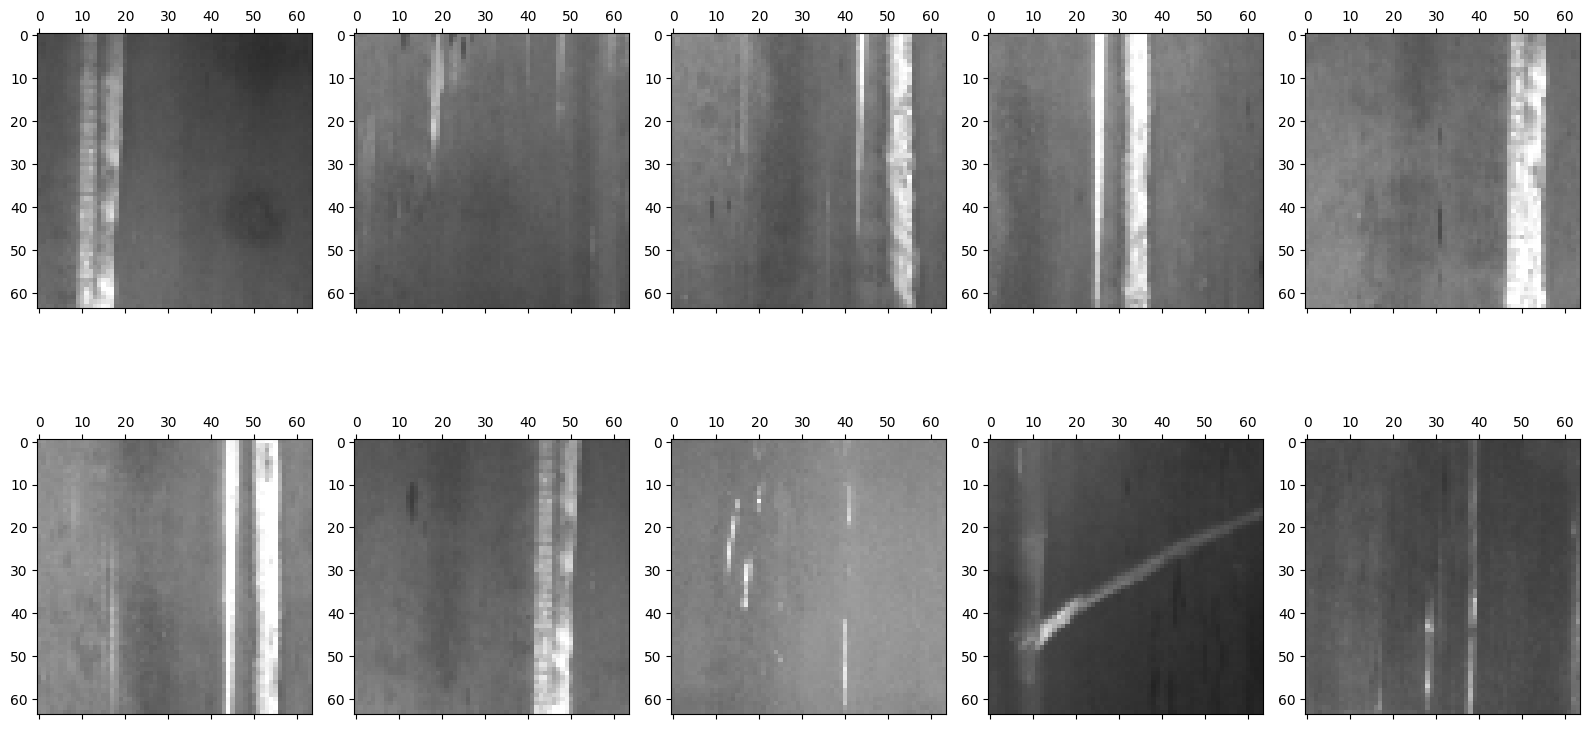

In [ ]:
# Display 10 real images from dataset:
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(data_lowres[n])
        n=n+1
plt.show()

In [ ]:
# Scaler call:
scaler=MinMaxScaler(feature_range=(-1, 1))

# copy images that we want to use for model training:
data=data_lowres.copy()
print("Original shape of the dataset: ", data.shape)

# Reshape array for fit:
data=data.reshape(-1, 1)
print("Reshaped dataset: ", data.shape)

# Fit the scaler:
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape:
data=data.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)   #the same of original, after fit scale.

Original shape of the data:  (286, 64, 64, 3)
Reshaped data:  (3514368, 1)
Shape of the scaled array:  (286, 64, 64, 3)


### 3. DCGAN

EXPLANATION:

1. Define generator model.
2. Define a discriminator model.
3. Combine generator and discriminator in a DCGAN.
_____________________________________________________
4. Sample a latent space.
5. Sample a real images.
6. Generate fakes images with generator.

#### Define Generator model

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 8192)             1646592   
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Resh  (None, 8, 8, 128)        0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 16, 16, 128)      262272    
 onv2DTranspose)                                                 
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-Hidden-Layer-3 (C  (None, 32, 32, 256)      52

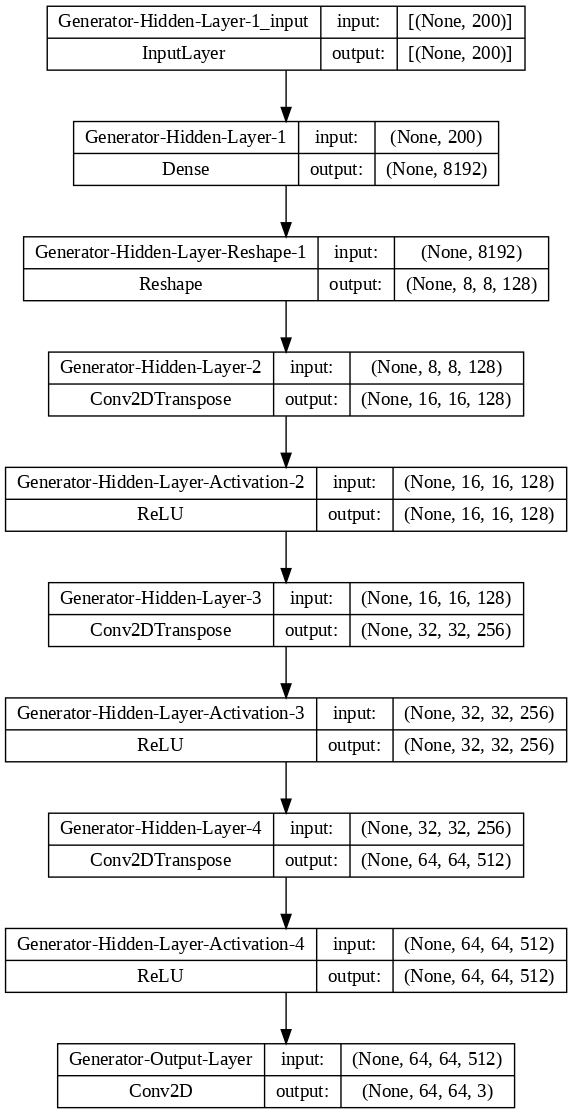

In [ ]:
def generator(latent_dim):
    model = Sequential(name="Generator")

    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of units in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))

    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))

    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))

    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model


# Instantiate
latent_dim=200 # Our latent space has 200 dimensions. it could be more.
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=100) #, to_file='generator_structure.png')

#### Define a Discriminator model

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       3136      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      131200    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 8, 8, 128)      

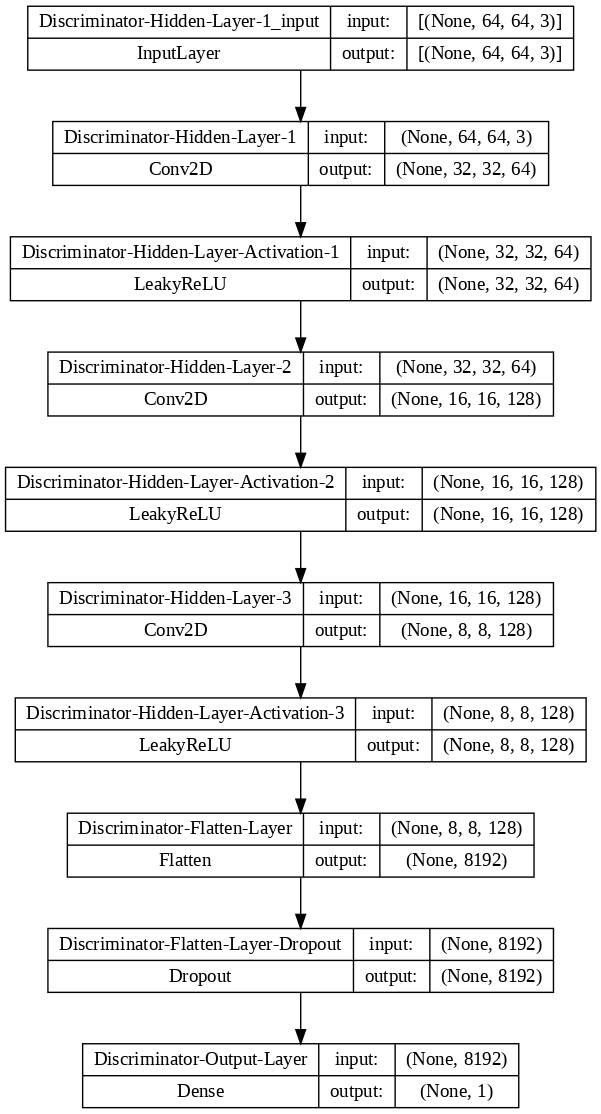

In [ ]:
def discriminator(in_shape=(64,64,3)):
    model = Sequential(name="Discriminator") # Model

    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))

    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))

    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))

    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model



# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=100) #, to_file='discriminator_structure.png')

#### Combine Generator and Discriminator models into trainable GAN

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         4569475   
                                                                 
 Discriminator (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4,974,276
Trainable params: 4,569,475
Non-trainable params: 404,801
_________________________________________________________________


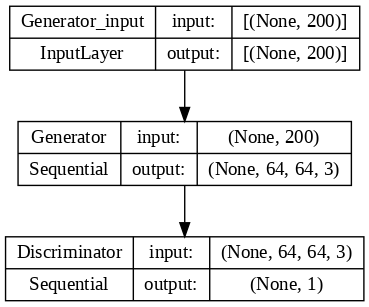

In [ ]:
def def_gan(generator, discriminator):

    # We don't want to train the weights of discriminator now. So, make it not trainable:
    discriminator.trainable = False

    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Discriminator

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model



# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=100) #, to_file='dcgan_structure.png')

### Step 4 - Setup functions to:
- sample real images
- sample the latent space
- generate fake images with the generator model

##### Sample real images

In [ ]:
def real_samples(n, dataset):
    #take samples from real data, including a column of labels 1=real
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels:
    y = np.ones((n, 1))  #set 1 to real images

    return X, y

##### Generate points in the latent space (use as inputs for the generator)

In [ ]:
def latent_vector(latent_dim, n):
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

##### Use the generator to generate n fake examples together with class labels

In [ ]:
def fake_samples(generator, latent_dim, n):
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)

    # generator take samples from latent space -->Predict outputs (generate fake samples)
    X = generator.predict(latent_output)

    # Create class labels
    y = np.zeros((n, 1))  #set zero to fake images
    return X, y

### 5. Model performance evaluation and training

##### Discriminator model accuracy and plot real v/s fake (generated) comparison

In [ ]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    x_real, y_real = real_samples(n, dataset)                                 # Get real samples
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)      # Evaluate the descriminator on real data (only accuracy)

    x_fake, y_fake = fake_samples(generator, latent_dim, n)                   # Get fake (generated) samples
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)      # Evaluate the descriminator on fake (generated) data
                                                                              # we dont want loss, only accuracy

    # print discriminator performance:
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE images: ", fake_accuracy)

    # Display 6 fake images:
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)       #inverse scale
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)           #back to the shape of images

    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show()

##### Train DCGAN model (generator and discriminator)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):
          #n_eval: for each 100 epochs, evaluate.
          #n_epochs: epochs
          #n_batch: batch
          #latent_dim: dimension of latent space
          #g,d,gan: models
          #dataset: dataset

    # Batch to train the discriminator will consist of half real images and half fake images:(balanced)
    half_batch = int(n_batch / 2)

    # We will manually enumerate epochs
    for i in range(n_epochs):

    # **********Discriminator training***********************************
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)

        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)

    # ***********Generator training***************************************
        # latent space used as inputs for the generator:
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, we want DCGAN generator model to create examples that resemble the real ones,
        # we want to pass labels corresponding to real samples, y=1, not 0.
        y_gan = np.ones((n_batch, 1))

        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)

        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

### 6. Train the model and plot results

##### Use train function to train DCGAN model

1/1 [==============================] - 3s 3s/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.6742868423461914
Generator Loss:  0.6937626600265503
2/2 [==============================] - 1s 860ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


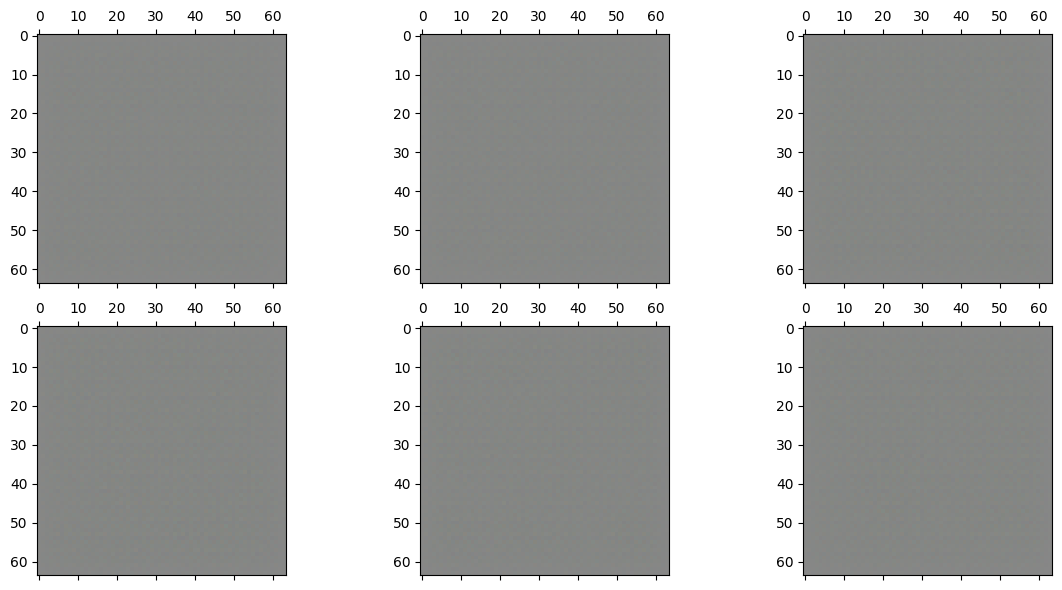

1/1 [==============================] - 0s 19ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.45354583859443665
Generator Loss:  0.8314012885093689
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


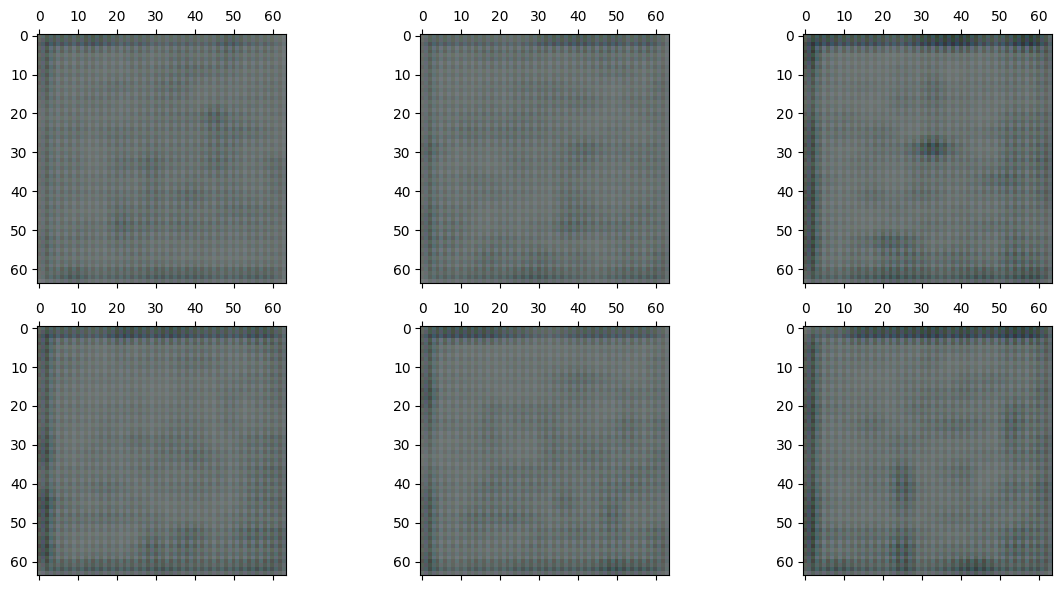

1/1 [==============================] - 0s 32ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.41093501448631287
Generator Loss:  1.1196112632751465
2/2 [==============================] - 0s 62ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  1.0


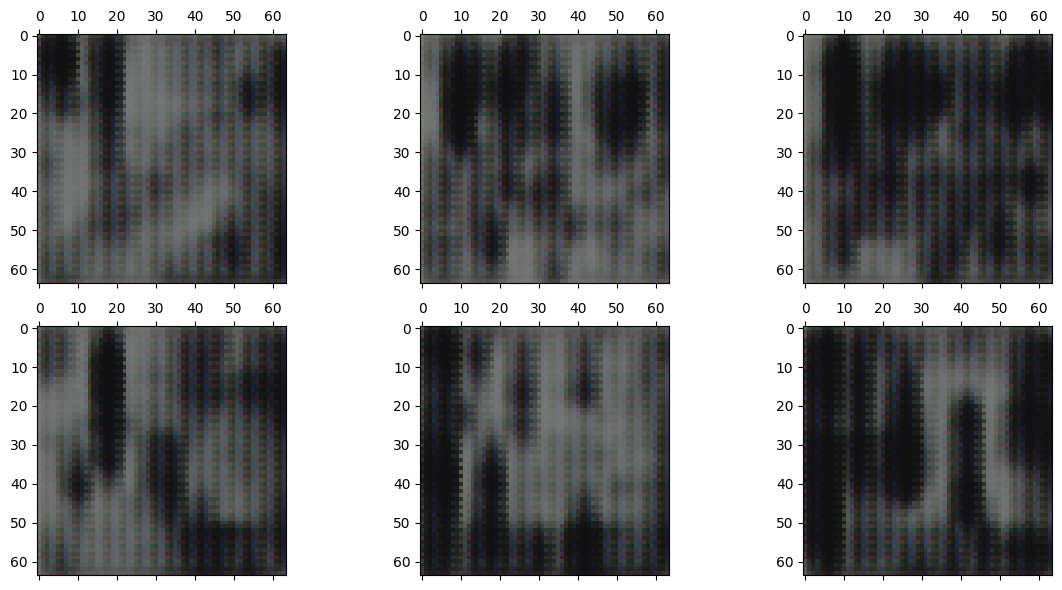

1/1 [==============================] - 0s 30ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.4428073763847351
Generator Loss:  1.0420544147491455
2/2 [==============================] - 0s 59ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6200000047683716
Discriminator Accuracy on FAKE (generated) images:  1.0


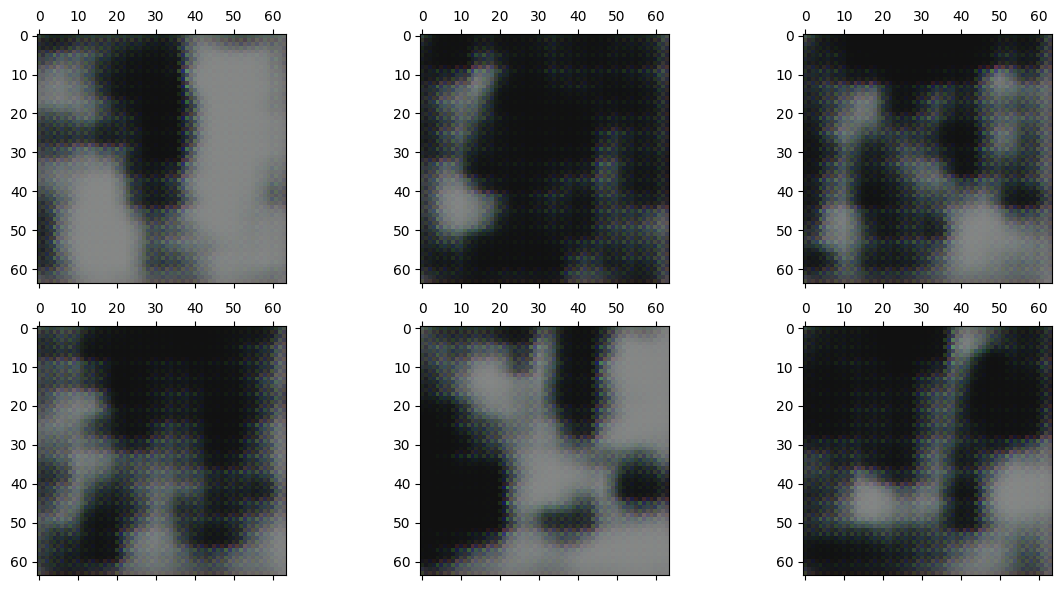

1/1 [==============================] - 0s 21ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.48978832364082336
Generator Loss:  1.207898497581482
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.4000000059604645
Discriminator Accuracy on FAKE (generated) images:  1.0


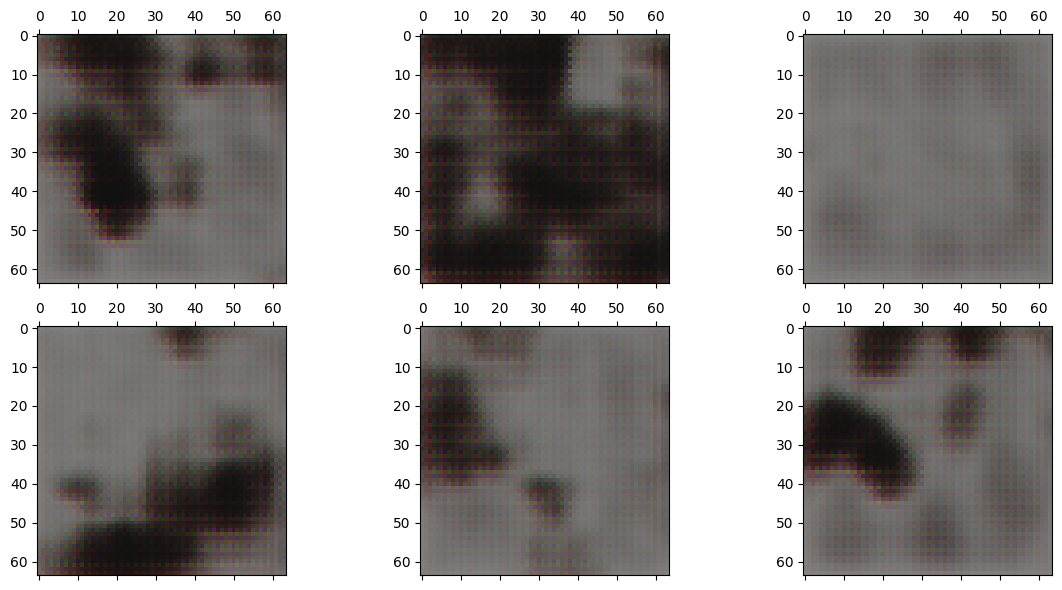

1/1 [==============================] - 0s 22ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.44700536131858826
Generator Loss:  0.8287700414657593
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  1.0


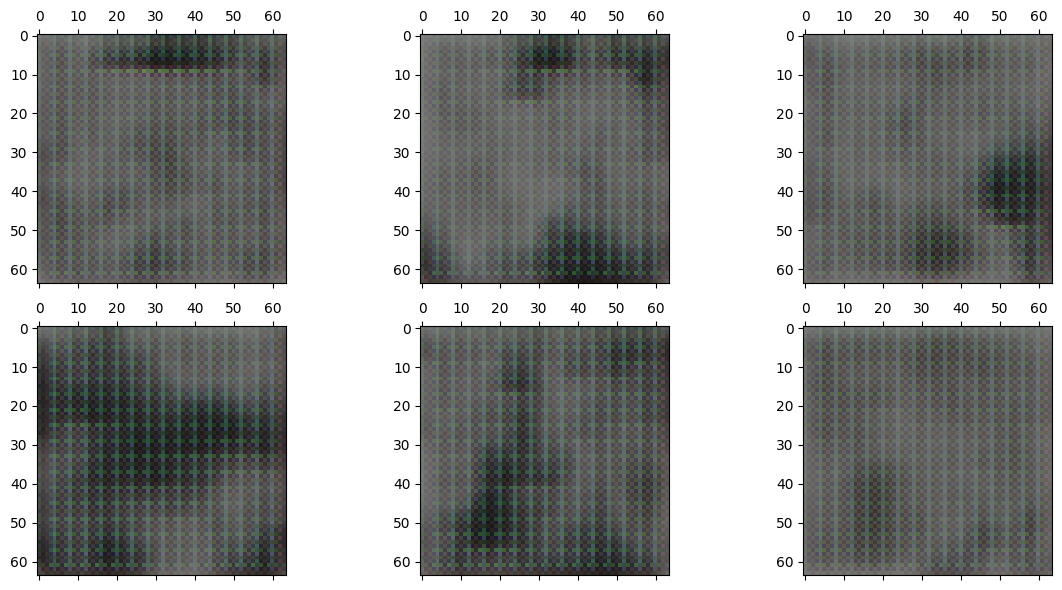

1/1 [==============================] - 0s 28ms/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.6572630405426025
Generator Loss:  0.75360506772995
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


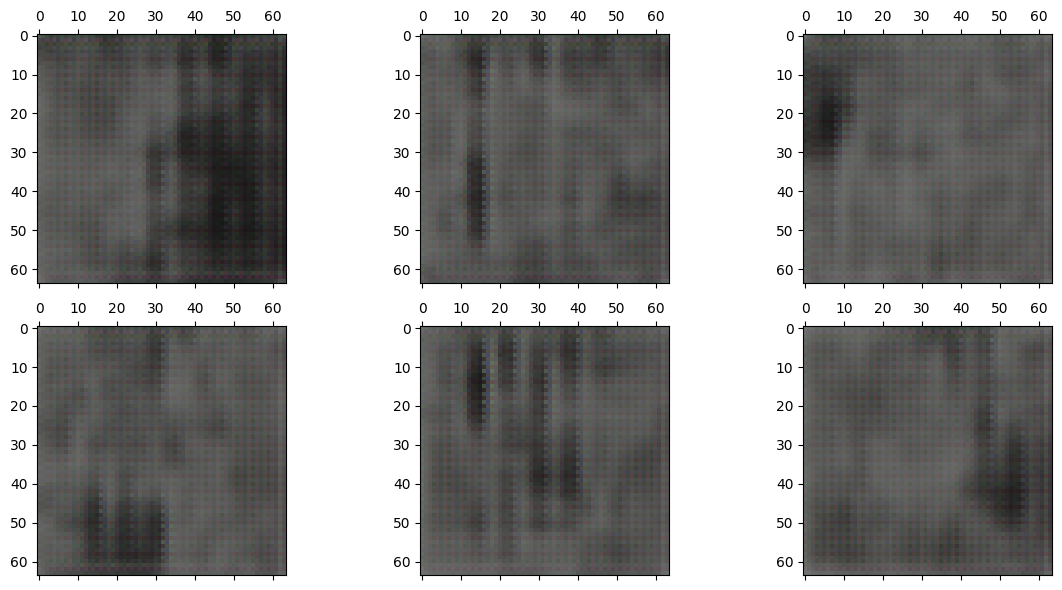

1/1 [==============================] - 0s 19ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.5715514421463013
Generator Loss:  1.6263041496276855
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.25999999046325684
Discriminator Accuracy on FAKE (generated) images:  1.0


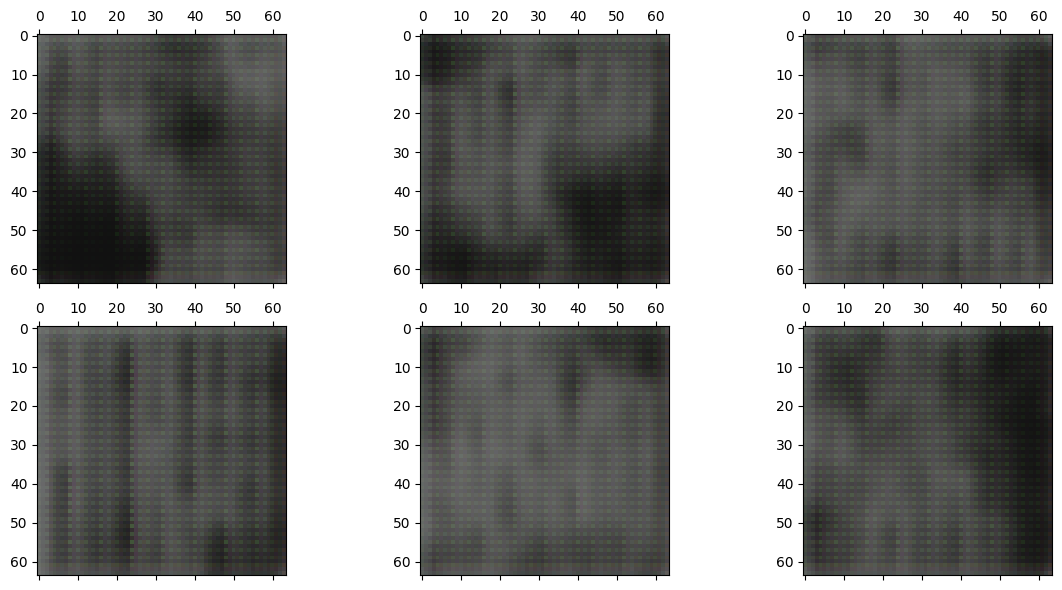

1/1 [==============================] - 0s 21ms/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.6084790229797363
Generator Loss:  0.8535609841346741
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5400000214576721
Discriminator Accuracy on FAKE (generated) images:  1.0


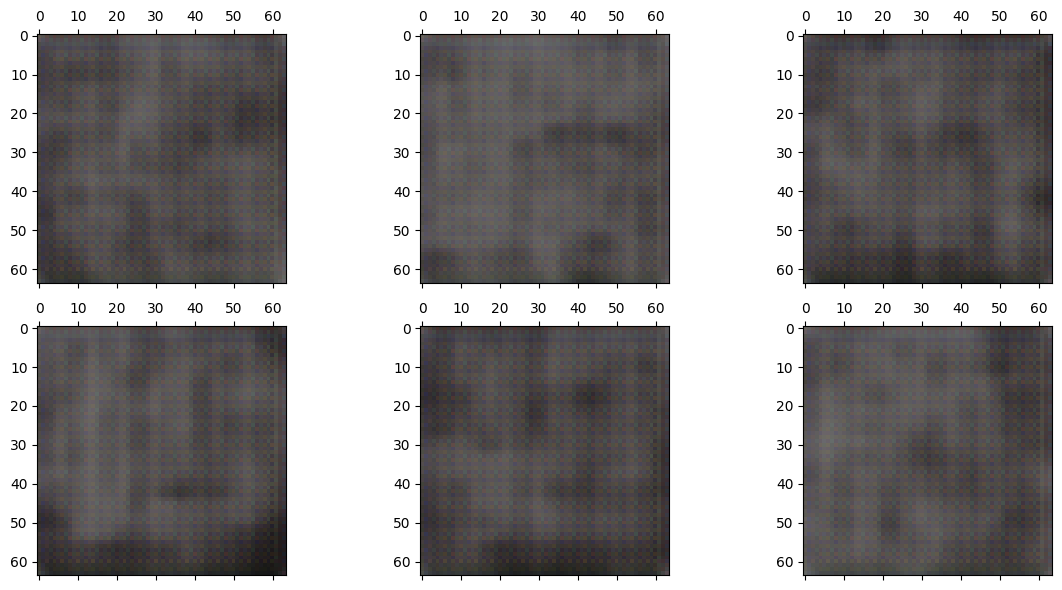

1/1 [==============================] - 0s 30ms/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.6888591051101685
Generator Loss:  0.6768722534179688
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6600000262260437
Discriminator Accuracy on FAKE (generated) images:  0.3199999928474426


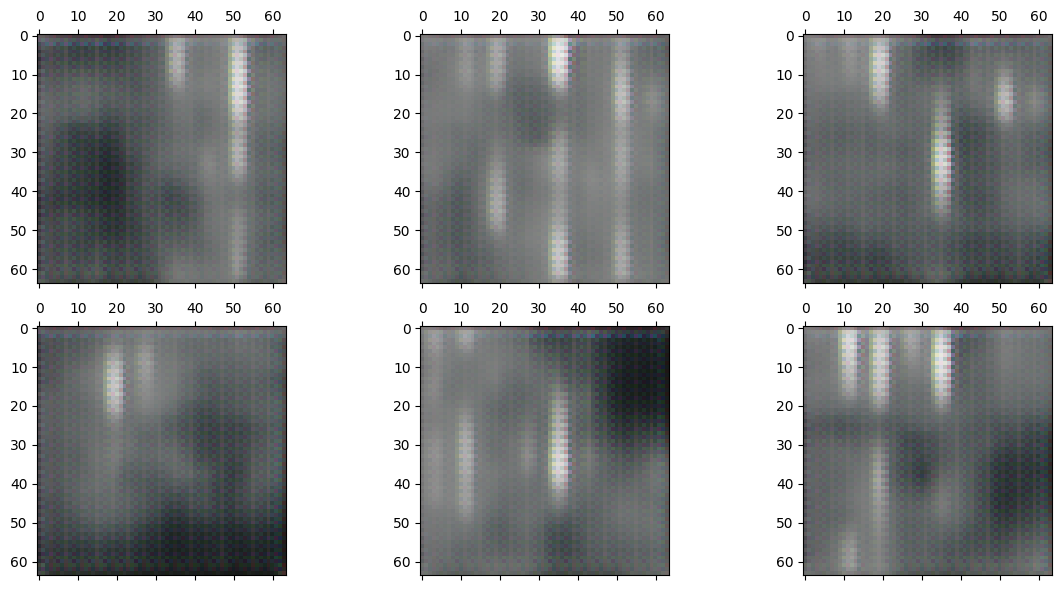

1/1 [==============================] - 0s 22ms/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.7062972187995911
Generator Loss:  0.7422173023223877
2/2 [==============================] - 0s 63ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.3400000035762787
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


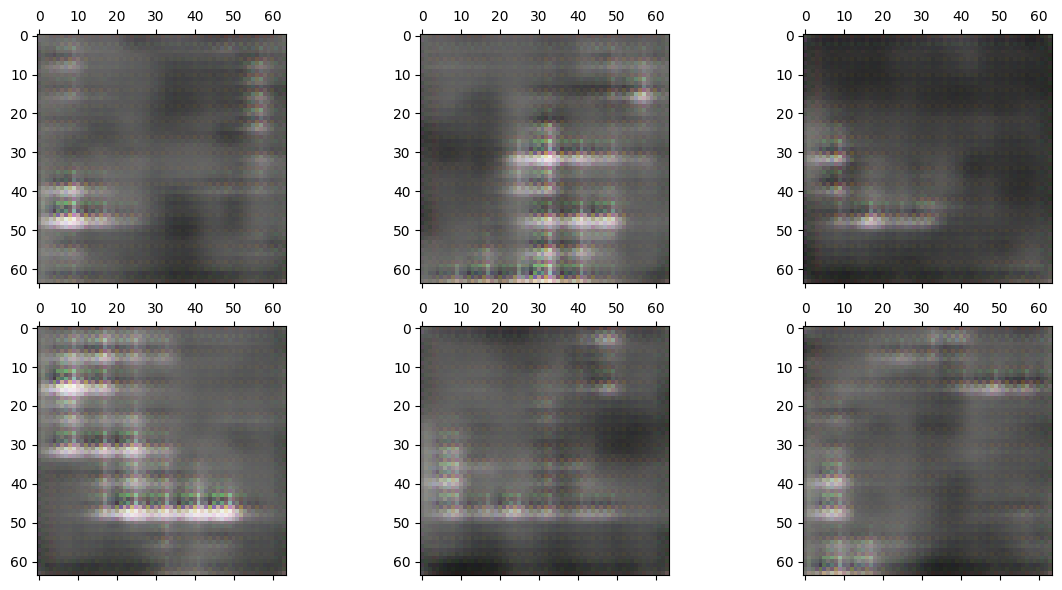

In [ ]:
# Train DCGAN model
# 1k epochs
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
# Save the current versions of the models (After 1k epochs)
gen_model.save(main_dir+"/data/saved_models/007a_Generator_metal_1k_200lat.h5")
dis_model.save(main_dir+"/data/saved_models/007a_Discriminator_metal_1k_200lat.h5")
gan_model.save(main_dir+"/data/saved_models/007a_GAN_metal_1k_200lat.h5")

1/1 [==============================] - 0s 18ms/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.7008465528488159
Generator Loss:  0.7477163076400757
2/2 [==============================] - 0s 65ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.3799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.7200000286102295


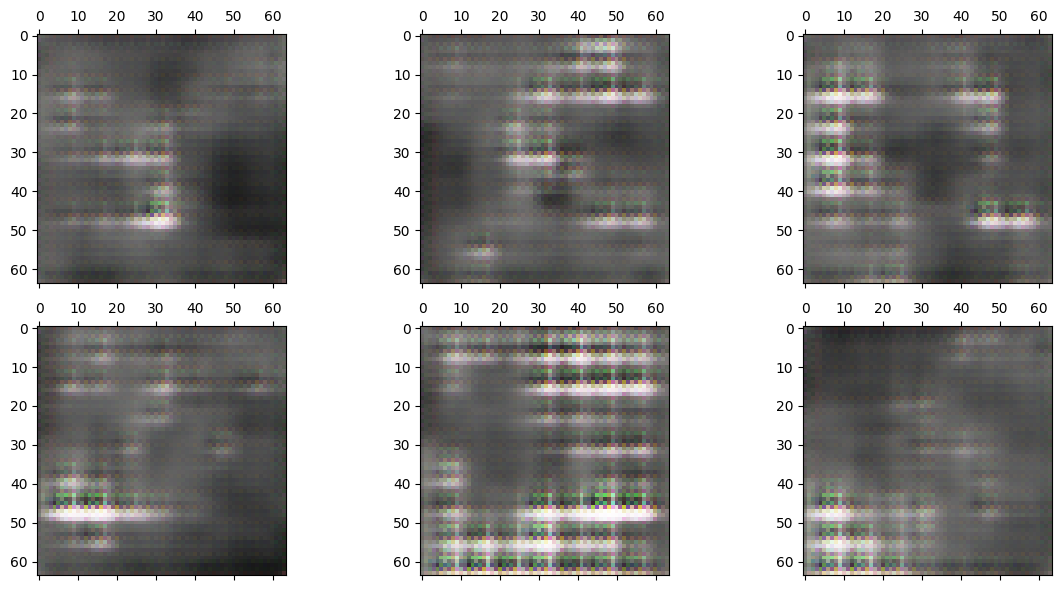

1/1 [==============================] - 0s 25ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.6791869401931763
Generator Loss:  0.8140333294868469
2/2 [==============================] - 0s 64ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.25999999046325684
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


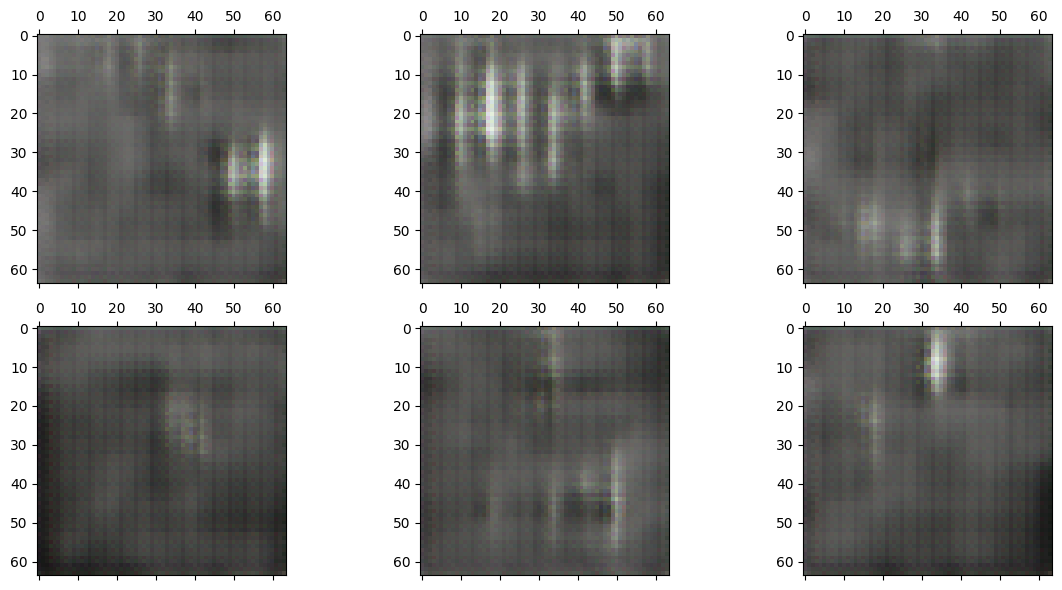

1/1 [==============================] - 0s 19ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.6718305349349976
Generator Loss:  0.6545243263244629
2/2 [==============================] - 0s 62ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9200000166893005
Discriminator Accuracy on FAKE (generated) images:  0.4000000059604645


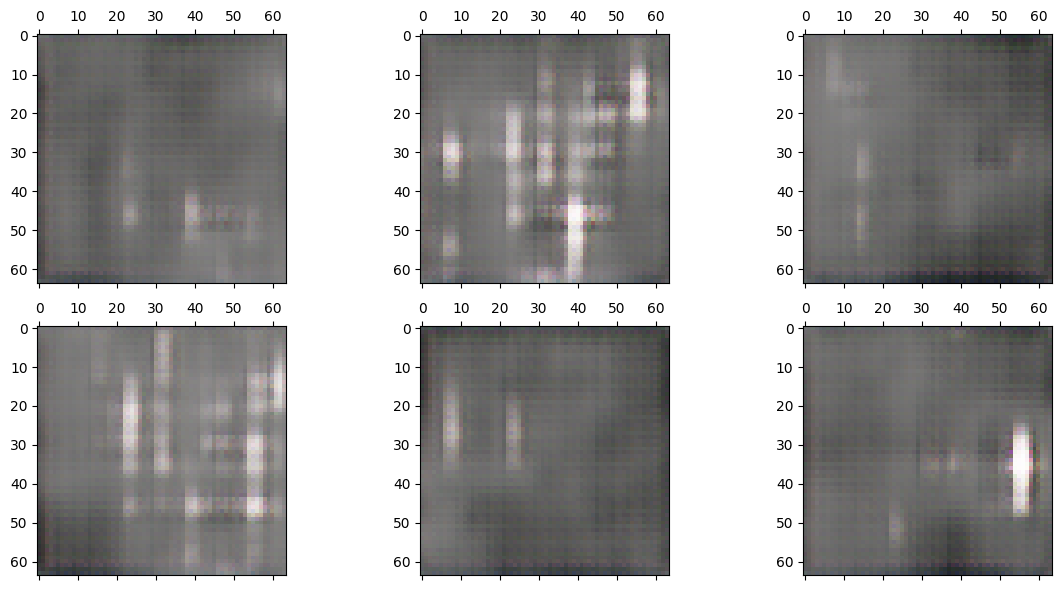

1/1 [==============================] - 0s 20ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.6657103300094604
Generator Loss:  1.0273053646087646
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.3199999928474426
Discriminator Accuracy on FAKE (generated) images:  1.0


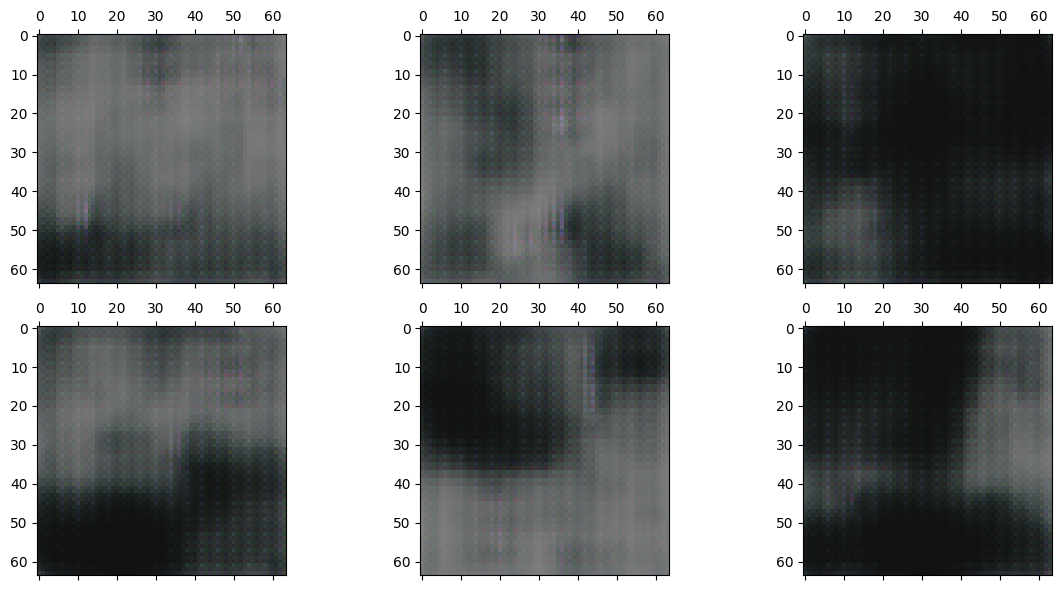

1/1 [==============================] - 0s 19ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.8130185008049011
Generator Loss:  0.7516499161720276
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.4000000059604645
Discriminator Accuracy on FAKE (generated) images:  0.36000001430511475


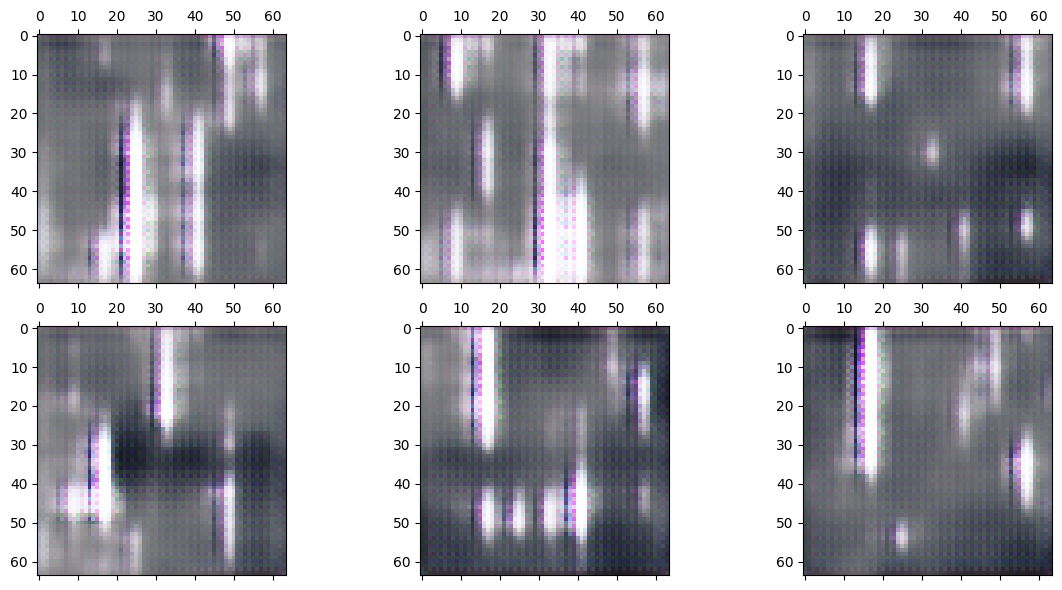

1/1 [==============================] - 0s 24ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.6356316208839417
Generator Loss:  0.7151302099227905
2/2 [==============================] - 0s 59ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.4399999976158142


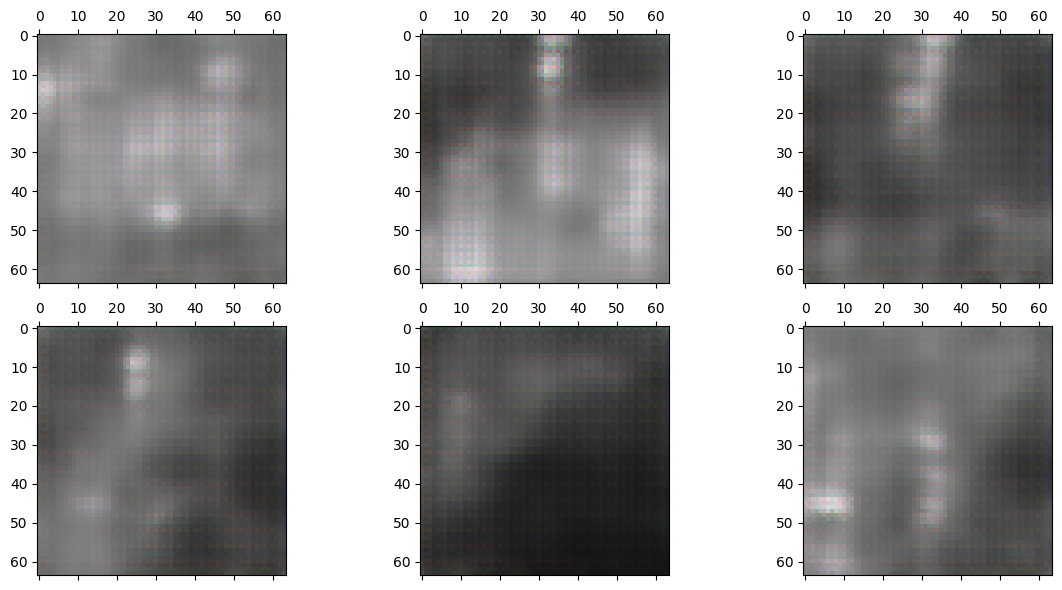

1/1 [==============================] - 0s 26ms/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.6215694546699524
Generator Loss:  0.7549590468406677
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7799999713897705
Discriminator Accuracy on FAKE (generated) images:  0.6000000238418579


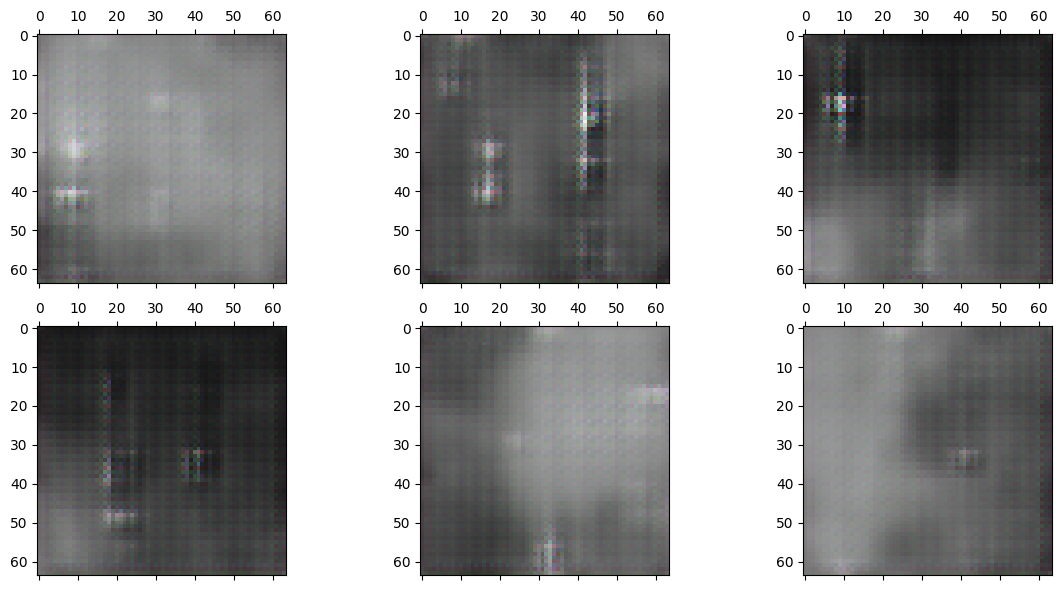

1/1 [==============================] - 0s 30ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.7099632024765015
Generator Loss:  0.777214527130127
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5600000023841858
Discriminator Accuracy on FAKE (generated) images:  0.30000001192092896


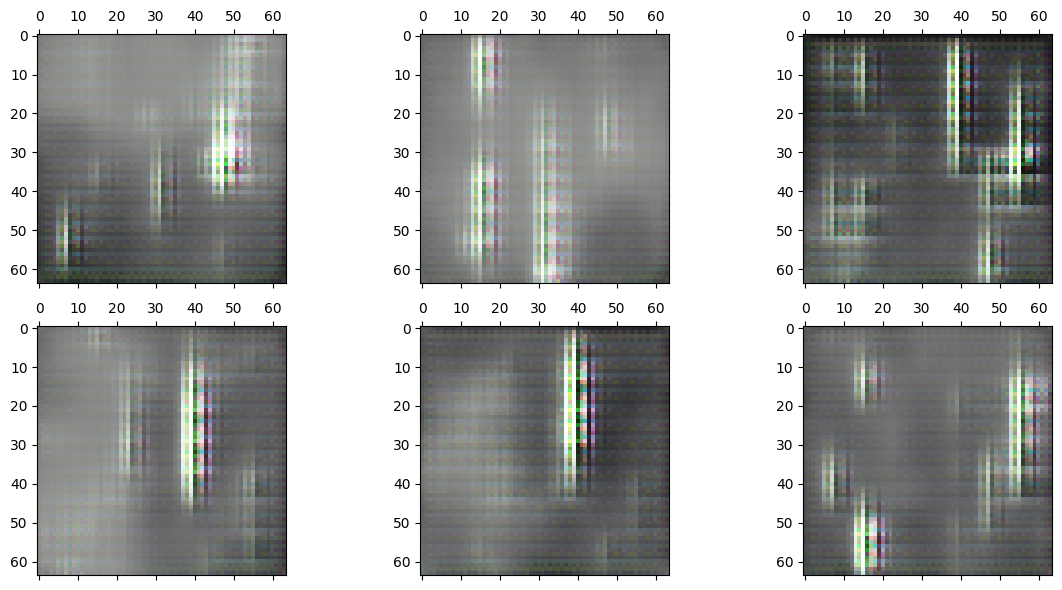

1/1 [==============================] - 0s 22ms/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.629425048828125
Generator Loss:  0.8750696778297424
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.46000000834465027
Discriminator Accuracy on FAKE (generated) images:  0.5400000214576721


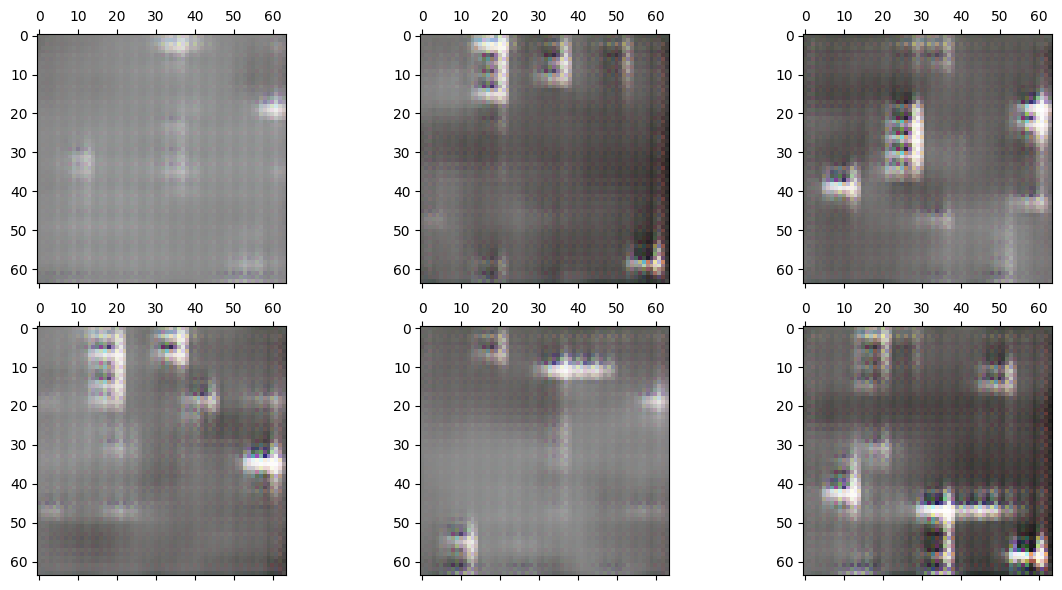

1/1 [==============================] - 0s 20ms/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.5713317394256592
Generator Loss:  0.985919713973999
2/2 [==============================] - 0s 59ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.3400000035762787
Discriminator Accuracy on FAKE (generated) images:  1.0


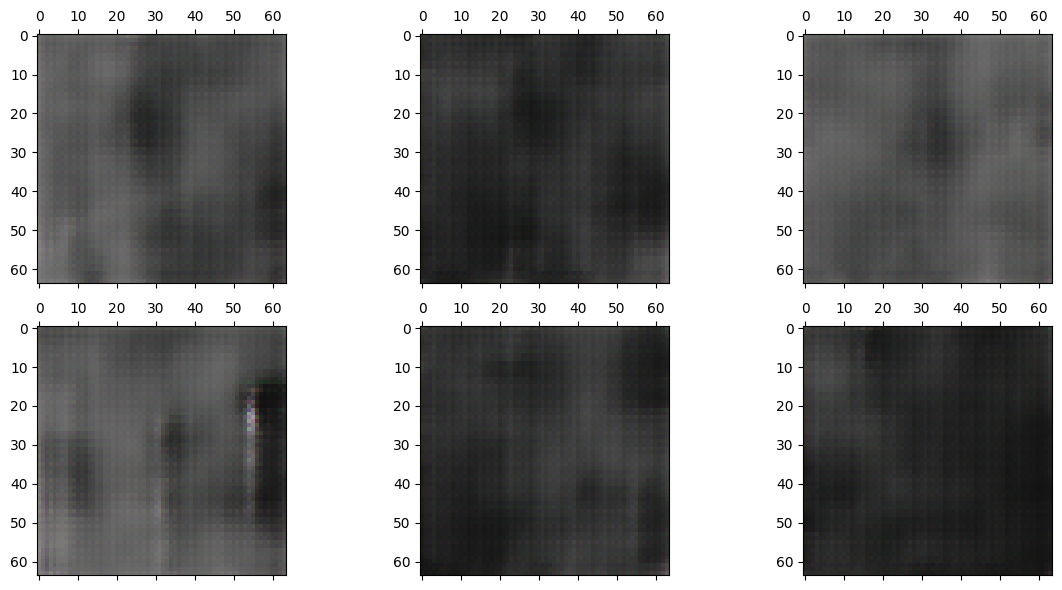

1/1 [==============================] - 0s 18ms/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.6186807751655579
Generator Loss:  0.8305779695510864
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.47999998927116394
Discriminator Accuracy on FAKE (generated) images:  0.8199999928474426


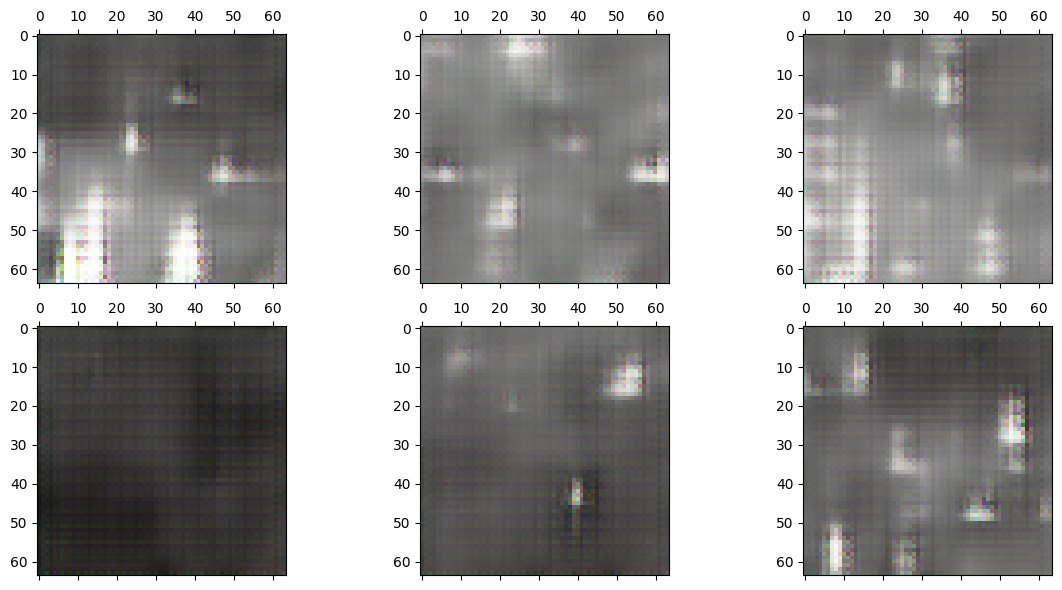

In [ ]:
# Continue training DCGAN model for another 1000 epochs (Total: 2K epochs)
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
# Save the current versions of the models (After 2k epcohs)
gen_model.save(main_dir+"/data/saved_models/007a_Generator_metal_2k_200lat.h5")
dis_model.save(main_dir+"/data/saved_models/007a_Discriminator_metal_2k_200lat.h5")
gan_model.save(main_dir+"/data/saved_models/007a_GAN_metal_2k_200lat.h5")

1/1 [==============================] - 0s 19ms/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.6750504970550537
Generator Loss:  0.8122451305389404
2/2 [==============================] - 0s 63ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5199999809265137
Discriminator Accuracy on FAKE (generated) images:  0.8199999928474426


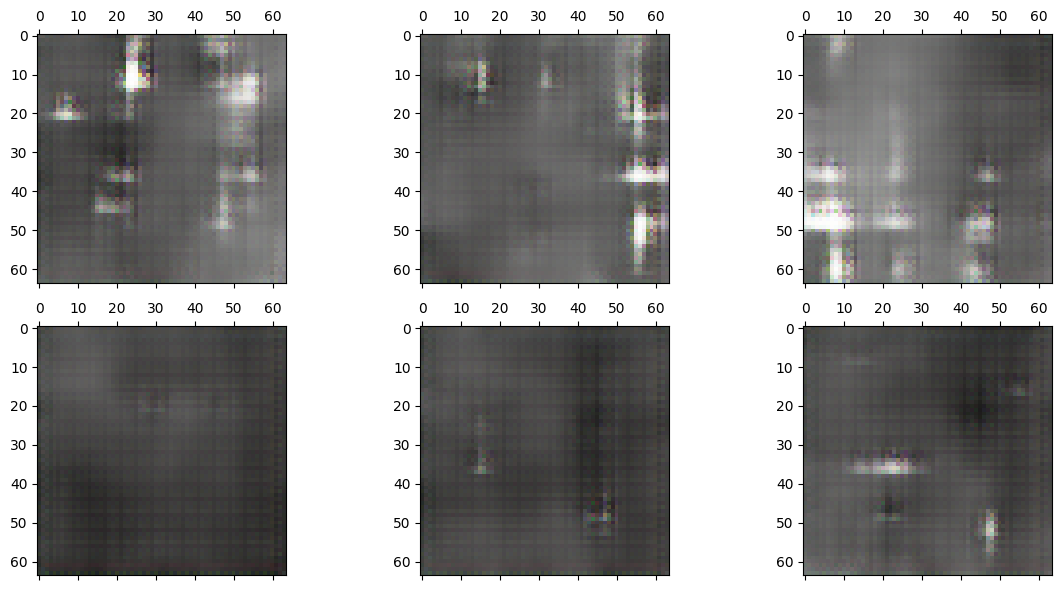

1/1 [==============================] - 0s 20ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.6341918706893921
Generator Loss:  1.134387493133545
2/2 [==============================] - 0s 62ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.3799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


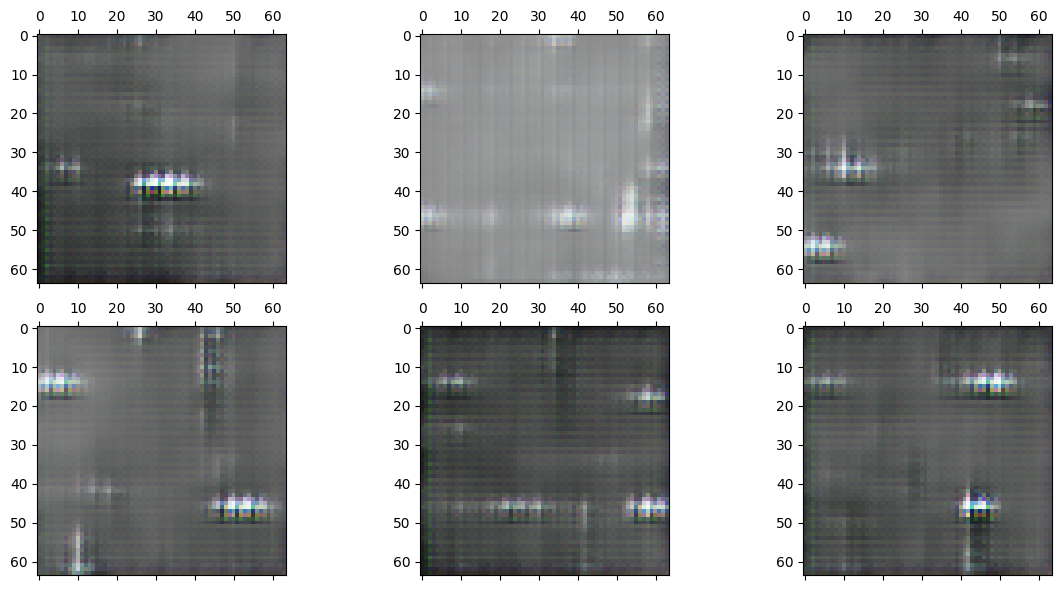

1/1 [==============================] - 0s 29ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.6226277351379395
Generator Loss:  0.8584767580032349
2/2 [==============================] - 0s 70ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.47999998927116394
Discriminator Accuracy on FAKE (generated) images:  0.9200000166893005


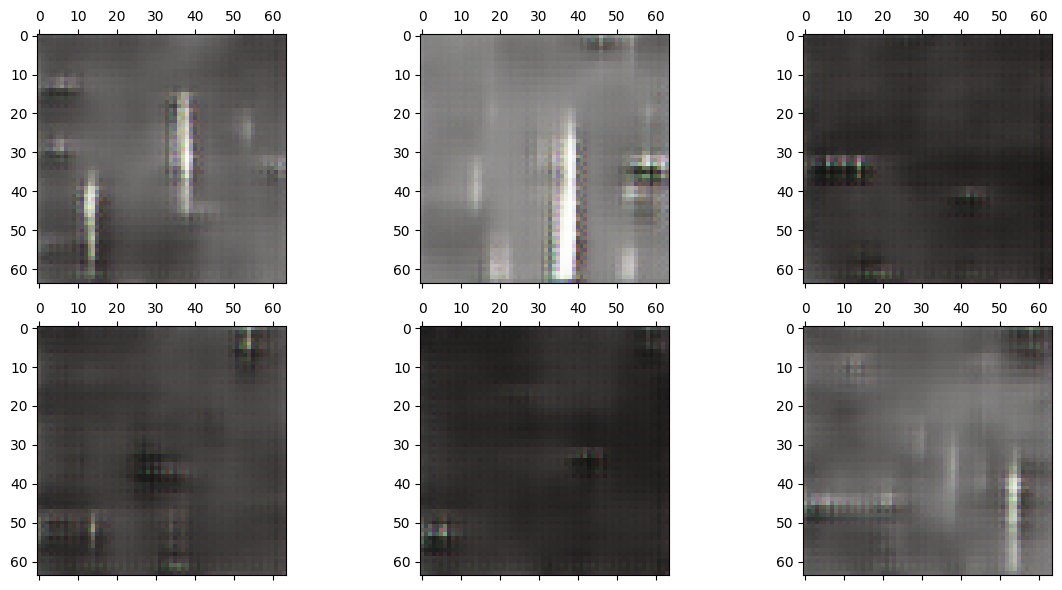

1/1 [==============================] - 0s 19ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.7819435596466064
Generator Loss:  0.6767510771751404
2/2 [==============================] - 0s 64ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  0.5799999833106995


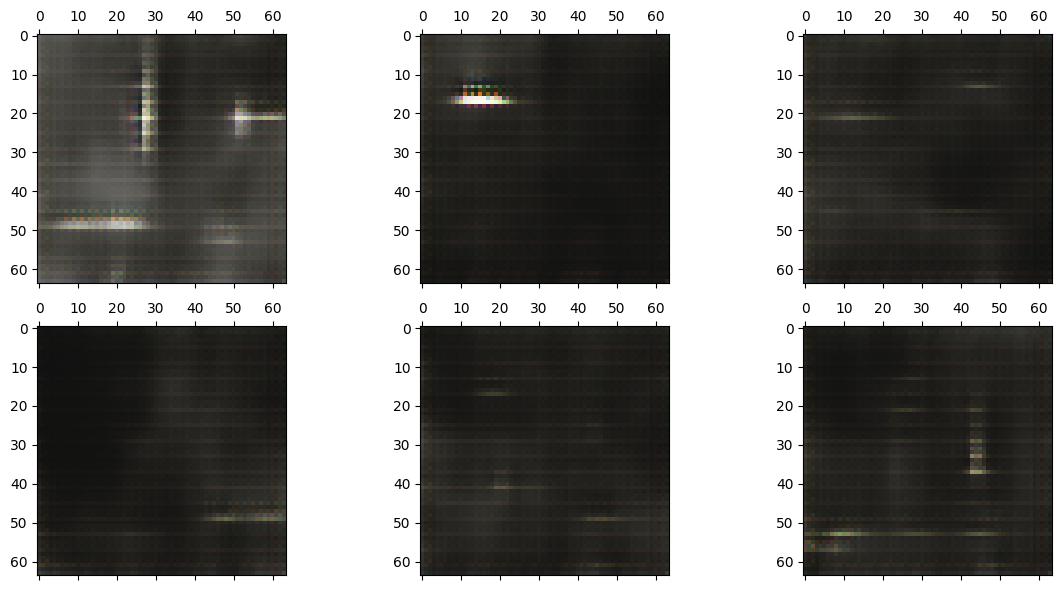

1/1 [==============================] - 0s 20ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.6726164221763611
Generator Loss:  1.0561031103134155
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.20000000298023224
Discriminator Accuracy on FAKE (generated) images:  0.800000011920929


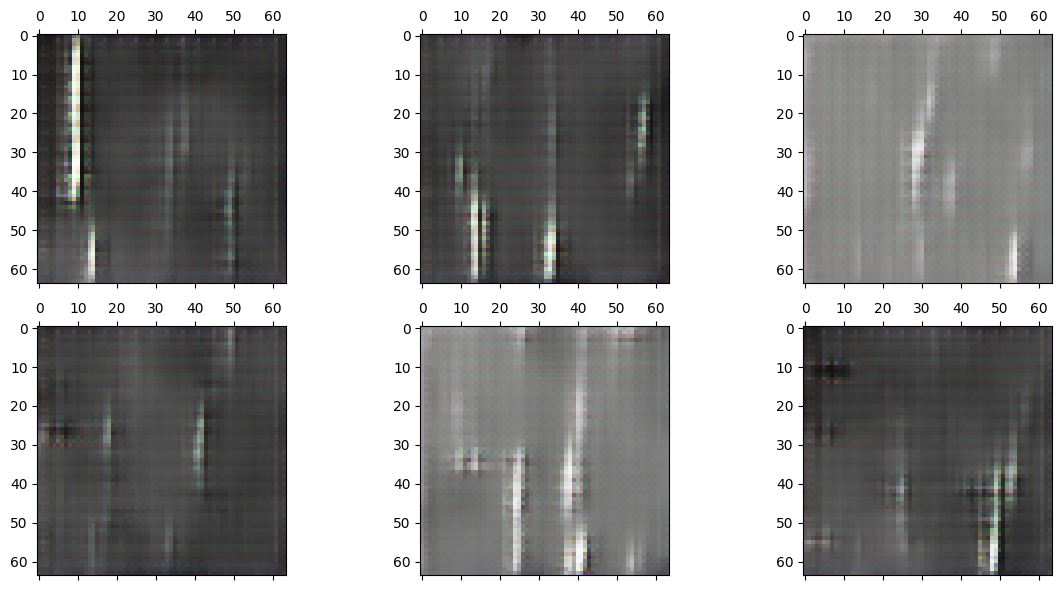

1/1 [==============================] - 0s 31ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.7224581837654114
Generator Loss:  0.7924635410308838
2/2 [==============================] - 0s 64ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6399999856948853
Discriminator Accuracy on FAKE (generated) images:  0.5199999809265137


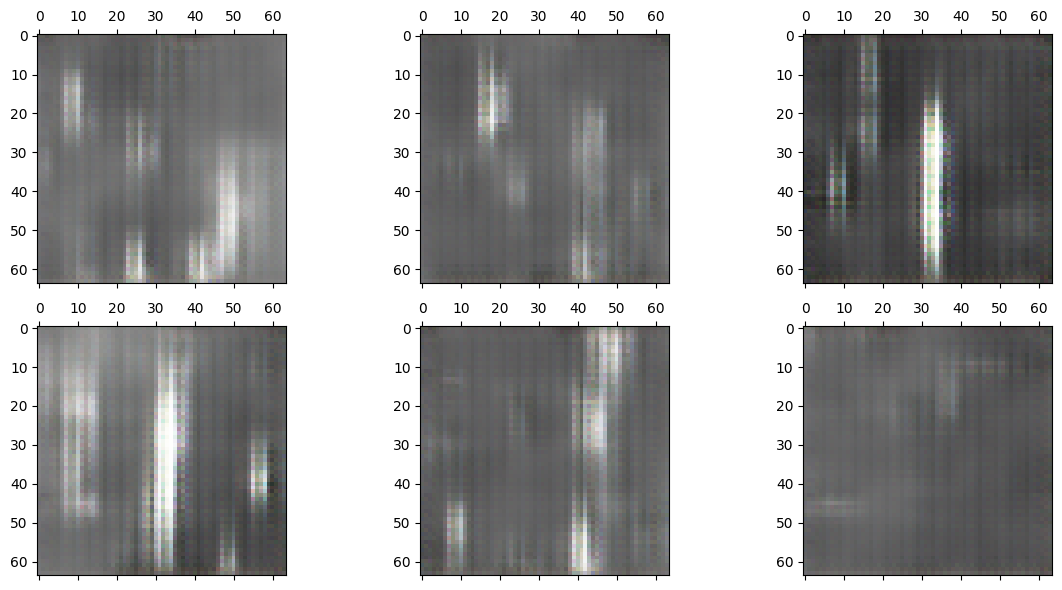

1/1 [==============================] - 0s 22ms/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.6422817707061768
Generator Loss:  0.7461620569229126
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


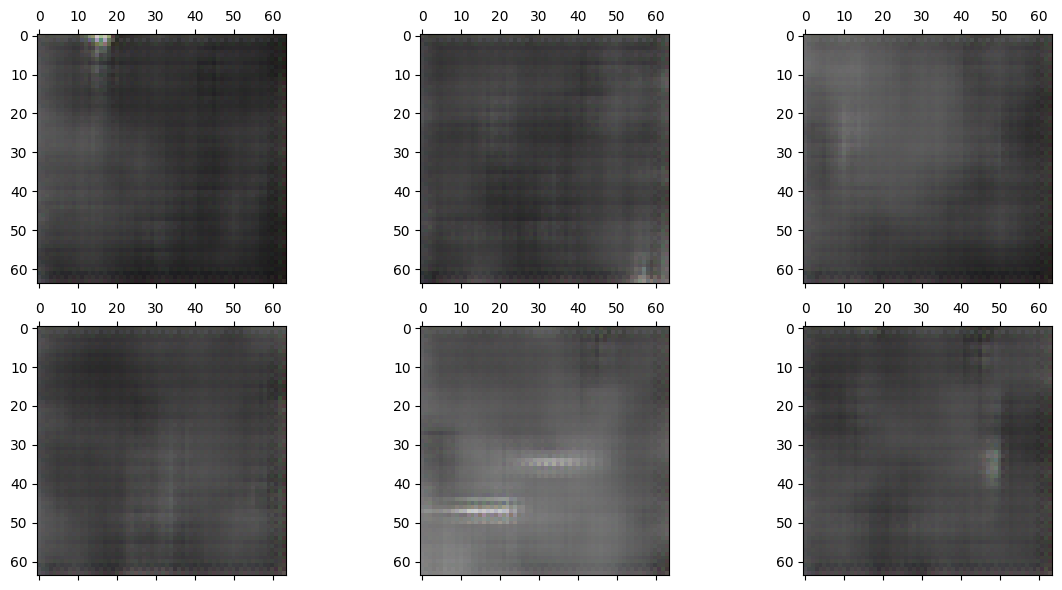

1/1 [==============================] - 0s 19ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.6270474791526794
Generator Loss:  0.8218902349472046
2/2 [==============================] - 0s 64ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5400000214576721
Discriminator Accuracy on FAKE (generated) images:  0.7599999904632568


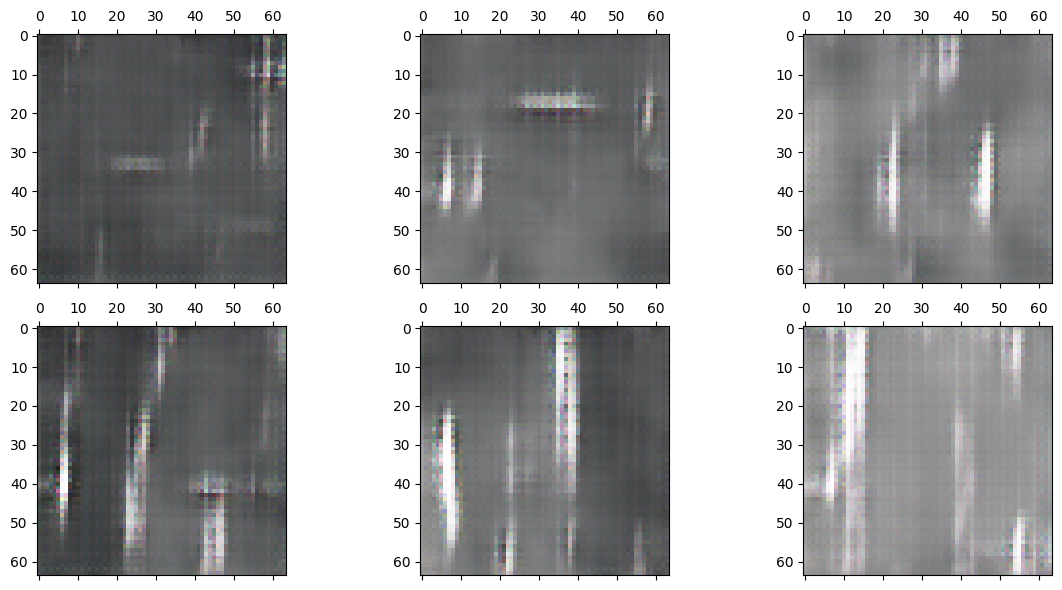

1/1 [==============================] - 0s 21ms/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.4865272045135498
Generator Loss:  0.9077804088592529
2/2 [==============================] - 0s 66ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  1.0


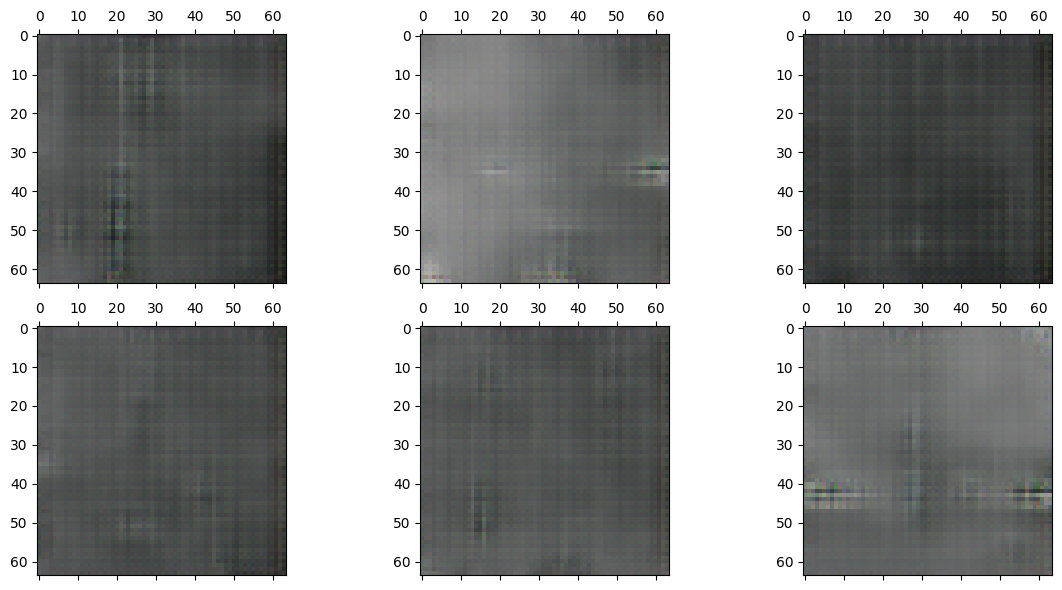

1/1 [==============================] - 0s 22ms/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.6178642511367798
Generator Loss:  0.7929661870002747
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.7400000095367432


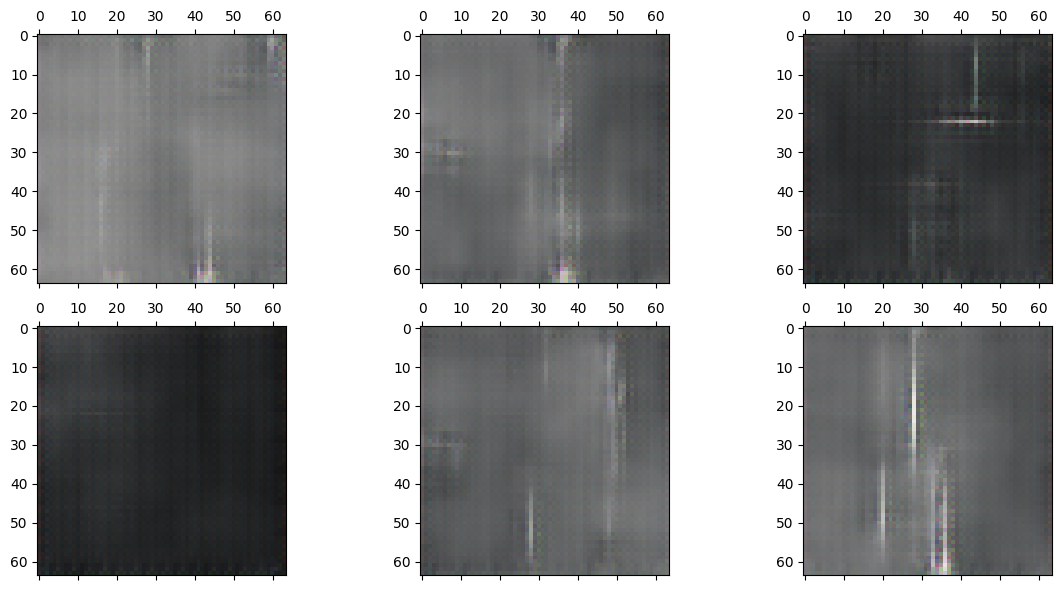

1/1 [==============================] - 0s 35ms/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.7147695422172546
Generator Loss:  0.9925241470336914
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.41999998688697815
Discriminator Accuracy on FAKE (generated) images:  0.800000011920929


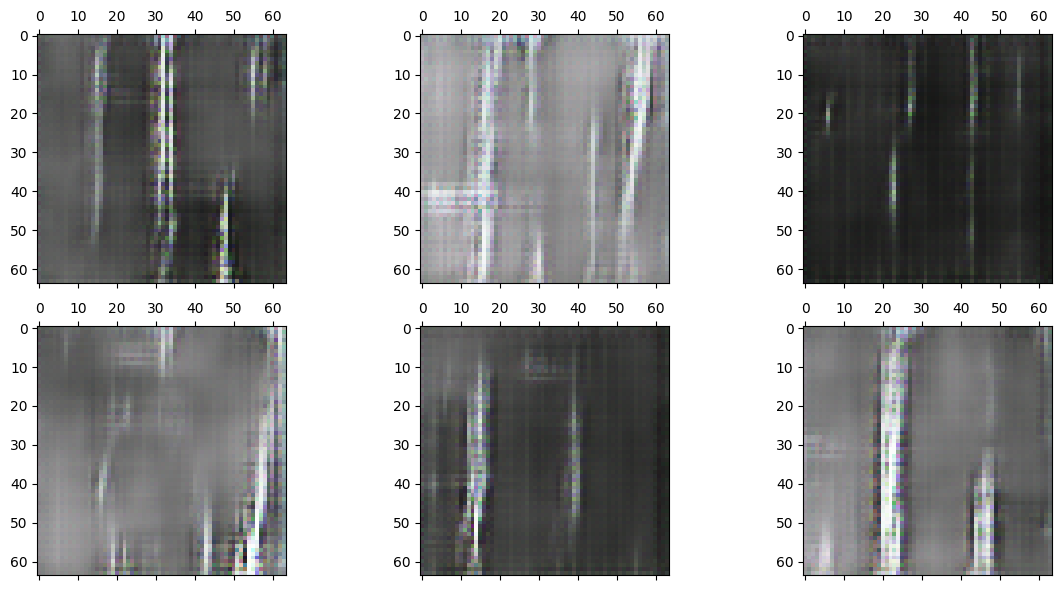

In [ ]:
# Continue training DCGAN model for another 1000 epochs (Total: 3K epochs)
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
# Save the current versions of the models (After 3k epcohs)
gen_model.save(main_dir+"/data/saved_models/007b_Generator_metal_3k.h5")
dis_model.save(main_dir+"/data/saved_models/007b_Discriminator_metal_3k.h5")
gan_model.save(main_dir+"/data/saved_models/007b_GAN_metal_3k.h5")

1/1 [==============================] - 0s 23ms/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.5529823303222656
Generator Loss:  1.1120870113372803
2/2 [==============================] - 0s 61ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.4000000059604645
Discriminator Accuracy on FAKE (generated) images:  0.8199999928474426


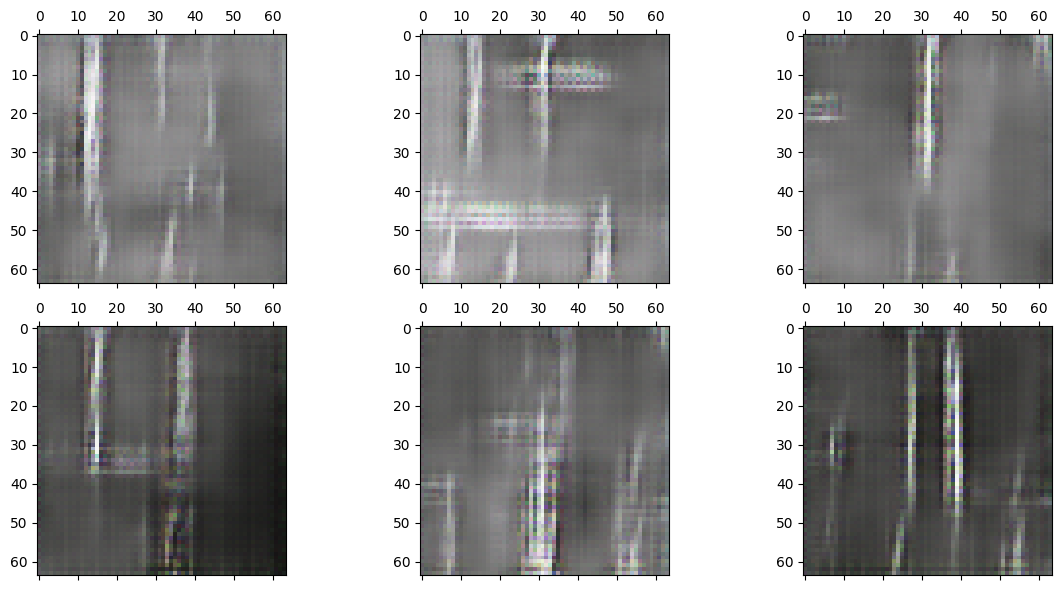

1/1 [==============================] - 0s 19ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.6399577260017395
Generator Loss:  0.9146040678024292
2/2 [==============================] - 0s 64ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.47999998927116394
Discriminator Accuracy on FAKE (generated) images:  0.800000011920929


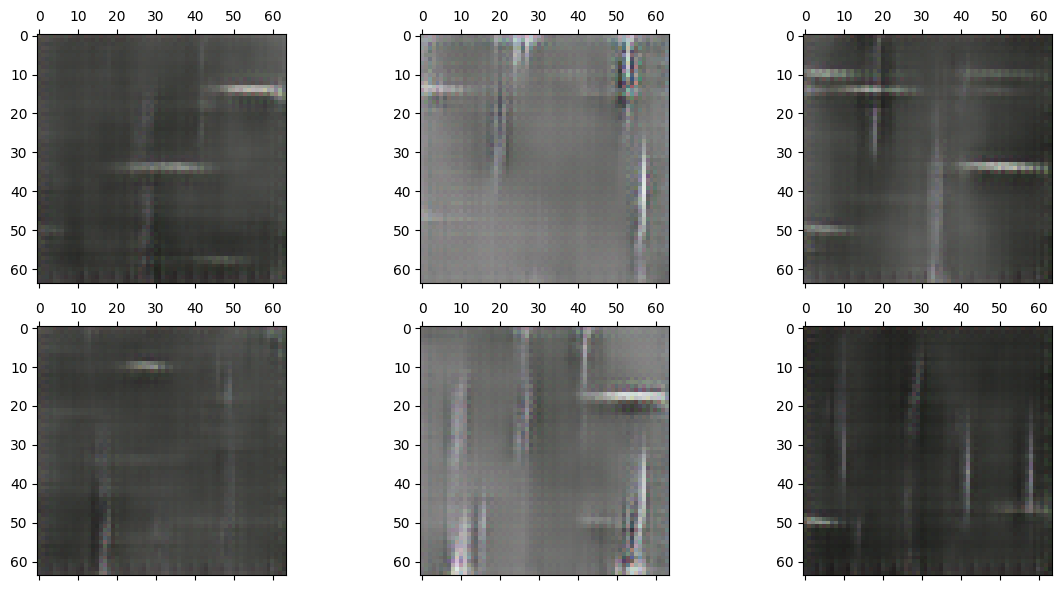

1/1 [==============================] - 0s 21ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.5425913333892822
Generator Loss:  0.779329776763916
2/2 [==============================] - 0s 64ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  0.6200000047683716


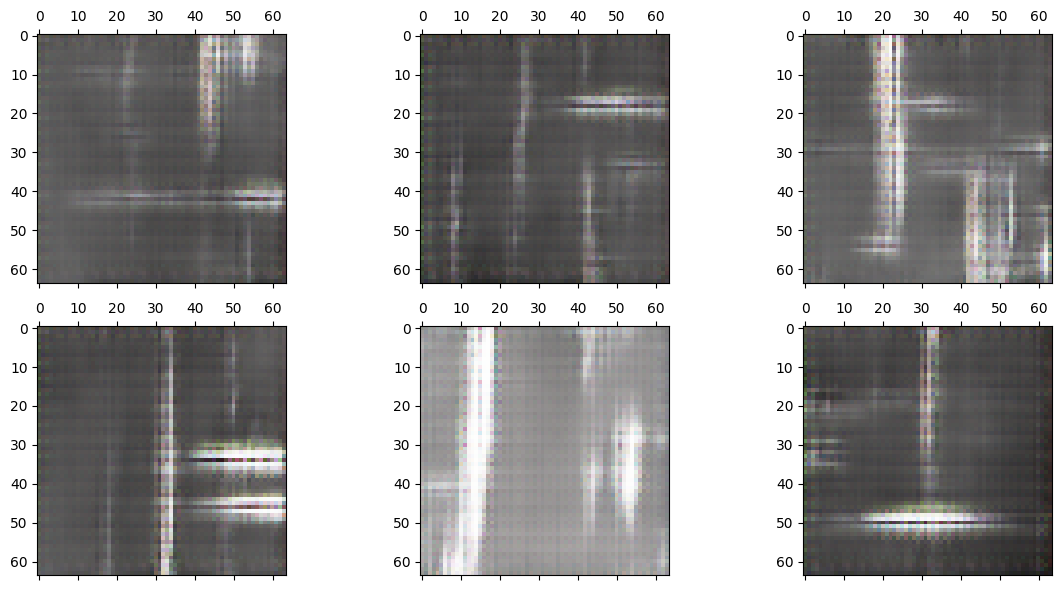

1/1 [==============================] - 0s 18ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.6749813556671143
Generator Loss:  0.9001541137695312
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5400000214576721
Discriminator Accuracy on FAKE (generated) images:  0.4000000059604645


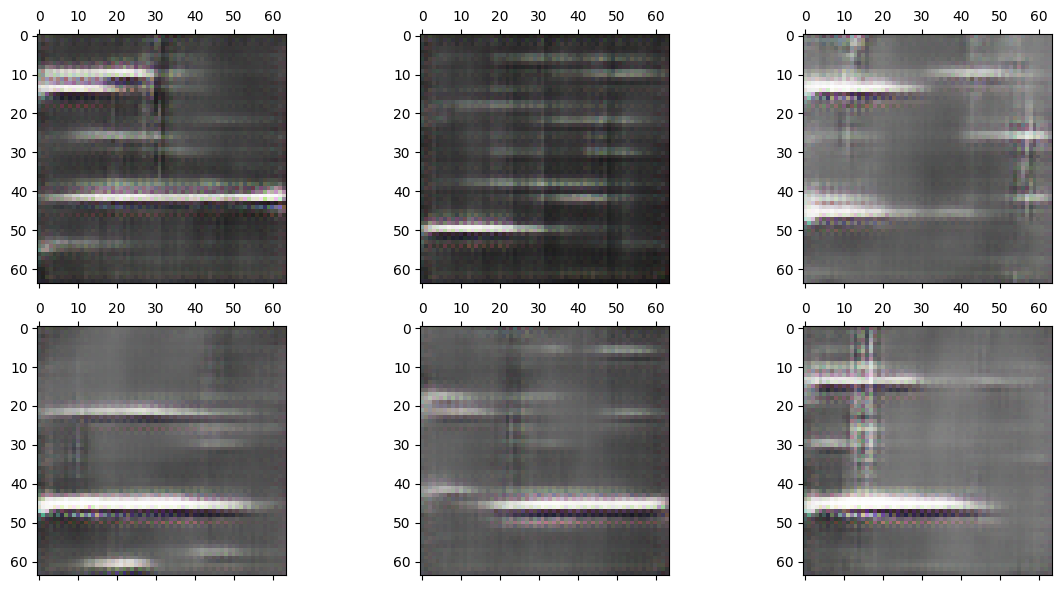

1/1 [==============================] - 0s 22ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.5469294190406799
Generator Loss:  0.9268090128898621
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5400000214576721
Discriminator Accuracy on FAKE (generated) images:  0.8999999761581421


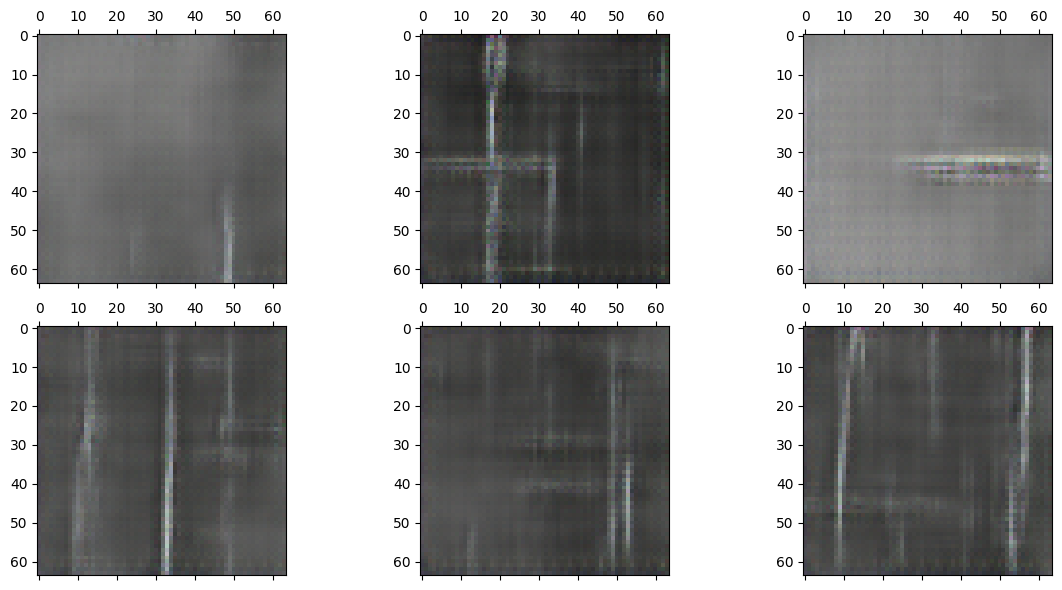

1/1 [==============================] - 0s 33ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.6464852094650269
Generator Loss:  0.8618156909942627
2/2 [==============================] - 0s 64ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.41999998688697815
Discriminator Accuracy on FAKE (generated) images:  0.7400000095367432


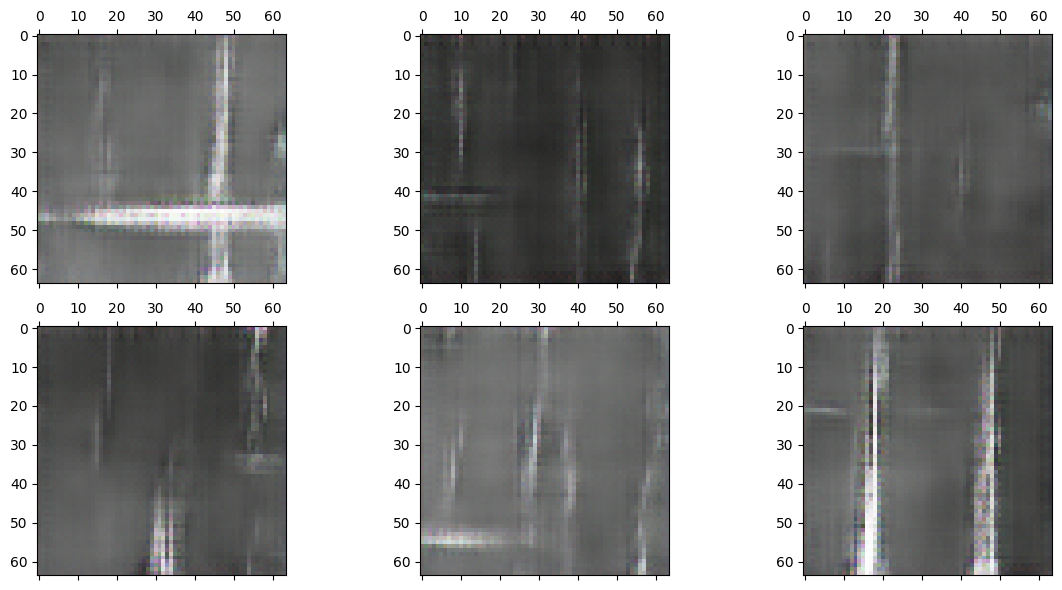

1/1 [==============================] - 0s 18ms/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.707388162612915
Generator Loss:  1.0580706596374512
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.36000001430511475
Discriminator Accuracy on FAKE (generated) images:  0.9200000166893005


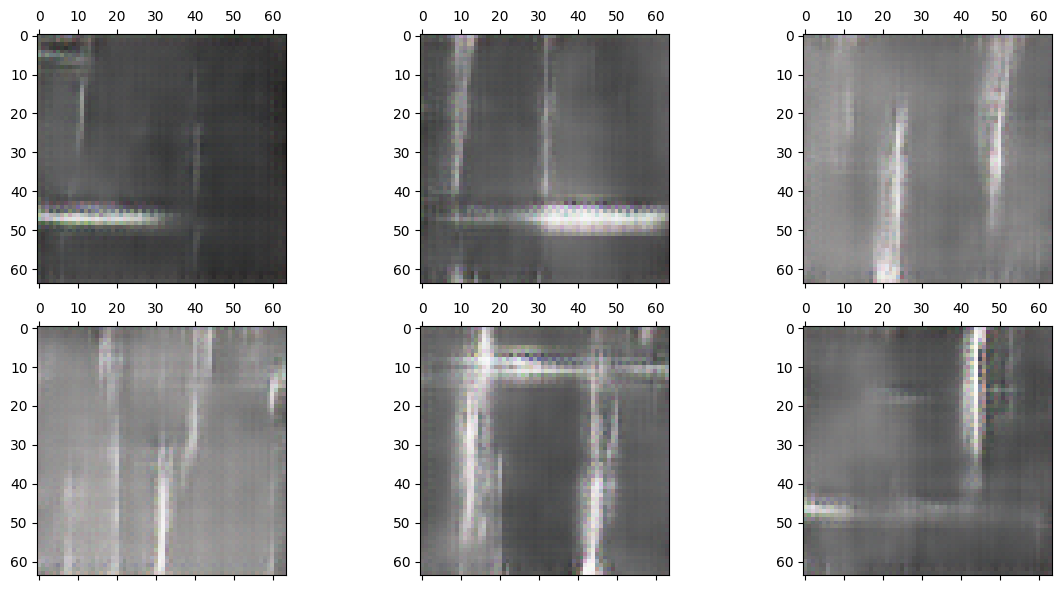

1/1 [==============================] - 0s 20ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.5665003061294556
Generator Loss:  0.9308698177337646
2/2 [==============================] - 0s 63ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5199999809265137
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


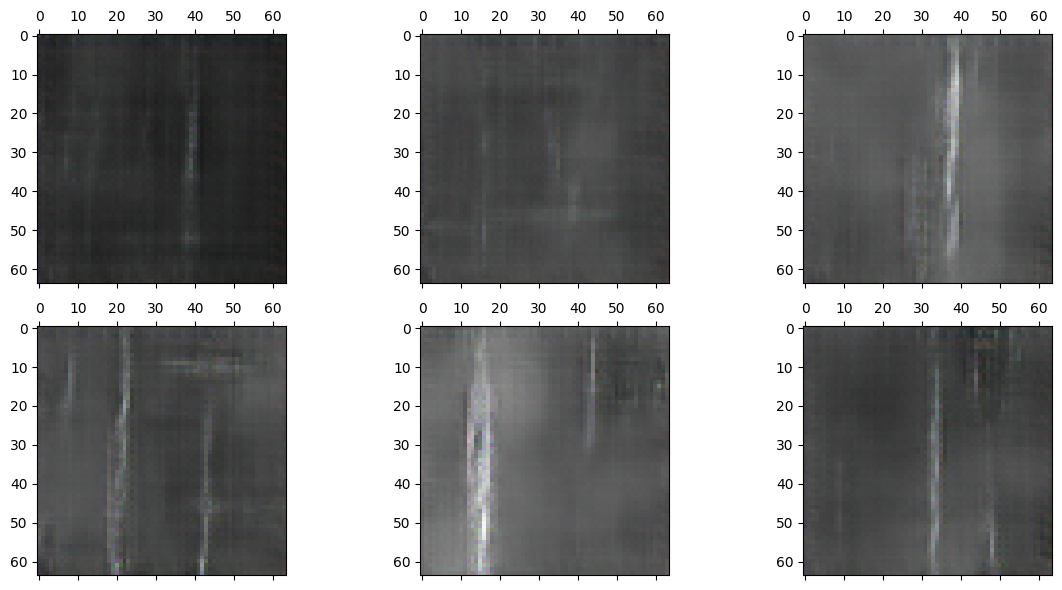

1/1 [==============================] - 0s 20ms/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.6046187281608582
Generator Loss:  1.0046184062957764
2/2 [==============================] - 0s 59ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5199999809265137
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


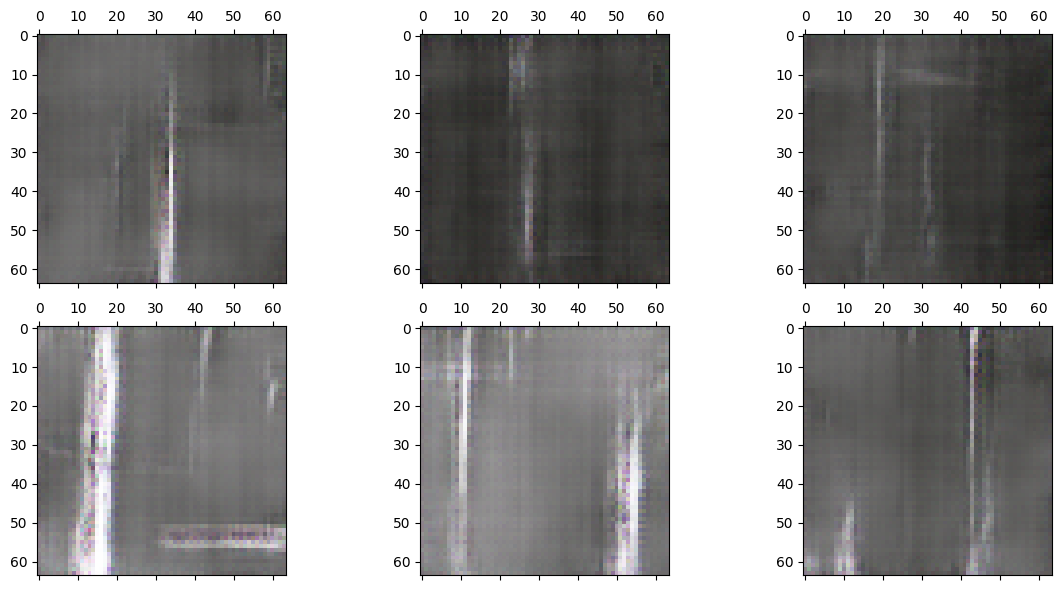

1/1 [==============================] - 0s 18ms/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.5856328010559082
Generator Loss:  0.90900719165802
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


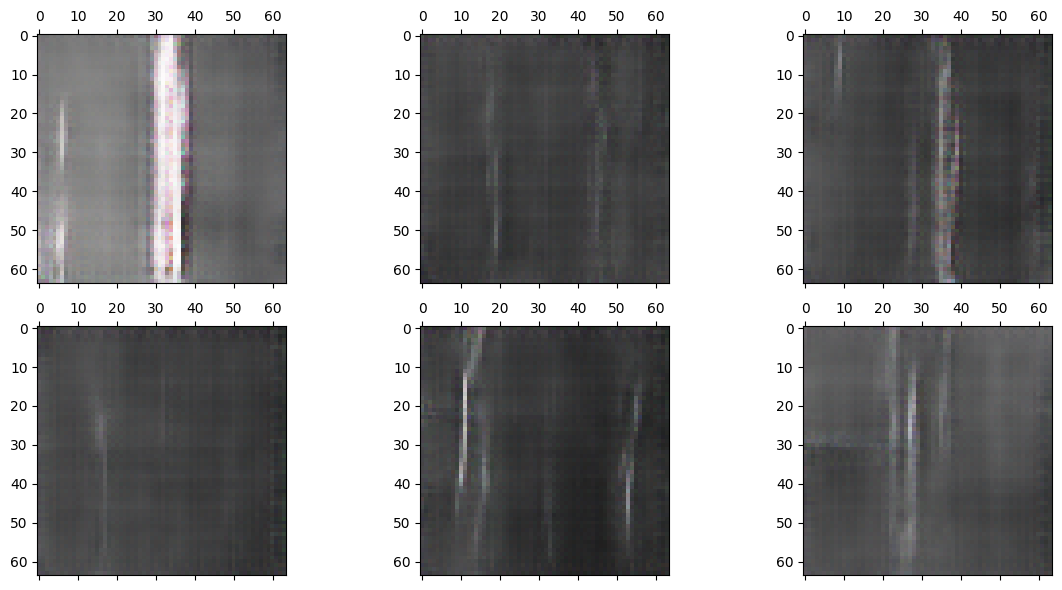

1/1 [==============================] - 0s 19ms/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.6462650299072266
Generator Loss:  0.8070096373558044
2/2 [==============================] - 0s 60ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5799999833106995
Discriminator Accuracy on FAKE (generated) images:  0.699999988079071


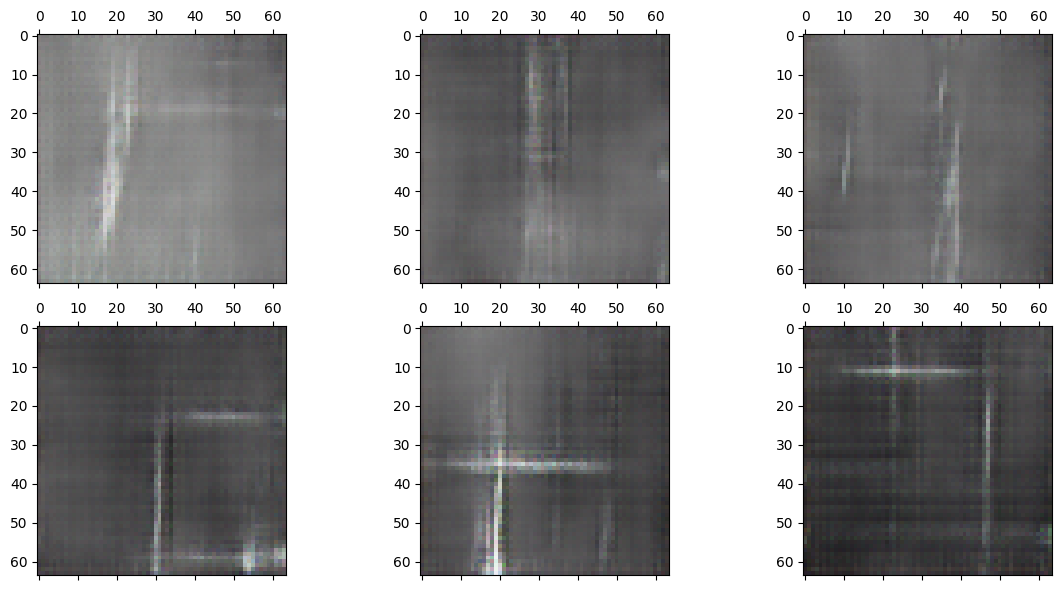

In [ ]:
# Continue training DCGAN model for another 1000 epochs (Total: 4K epochs)
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
# Save the current versions of the models (After 3k epcohs)
gen_model.save(main_dir+"/data/saved_models/007b_Generator_metal_4k_200lat.h5")
dis_model.save(main_dir+"/data/saved_models/007b_Discriminator_metal_4k_200lat.h5")
gan_model.save(main_dir+"/data/saved_models/007b_GAN_metal_4k_200lat.h5")

##### Example how to load a previously saved model

In [ ]:
# Add library
from keras.models import load_model
# Load saved models
gen_model = load_model(main_dir+"/data/saved_models/007b_Generator_metal_3k.h5")
dis_model = load_model(main_dir+"/data/saved_models/007b_Discriminator_metal_3k.h5")
gan_model = load_model(main_dir+"/data/saved_models/007b_GAN_metal_3k.h5")

In [ ]:
# Add library
from keras.models import load_model
# Load saved models
gen_model = load_model(main_dir+"/data/saved_models/007b_Generator_metal_4k.h5")
dis_model = load_model(main_dir+"/data/saved_models/007b_Discriminator_metal_4k.h5")
gan_model = load_model(main_dir+"/data/saved_models/007b_GAN_metal_4k.h5")

---

### Step 7 - Evaluate model performace and use the Generator to create a bunch of images

In [ ]:
def performance_eval(epoch, generator, discriminator, dataset, latent_dim, n=40):

    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)

    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)

    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print("Epoch number: ", epoch)
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)

    # Create a 2D scatter plot to show real and fake (generated) data points
    # Display 20 fake images
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)

    fig, axs = plt.subplots(8, 5, sharey=False, tight_layout=True, figsize=(48,48), facecolor='white')
    k=0
    for i in range(0,8):
        for j in range(0,5):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show()

2/2 [==============================] - 1s 598ms/step
Epoch number:  0
Discriminator Accuracy on REAL images:  0.574999988079071
Discriminator Accuracy on FAKE (generated) images:  0.875


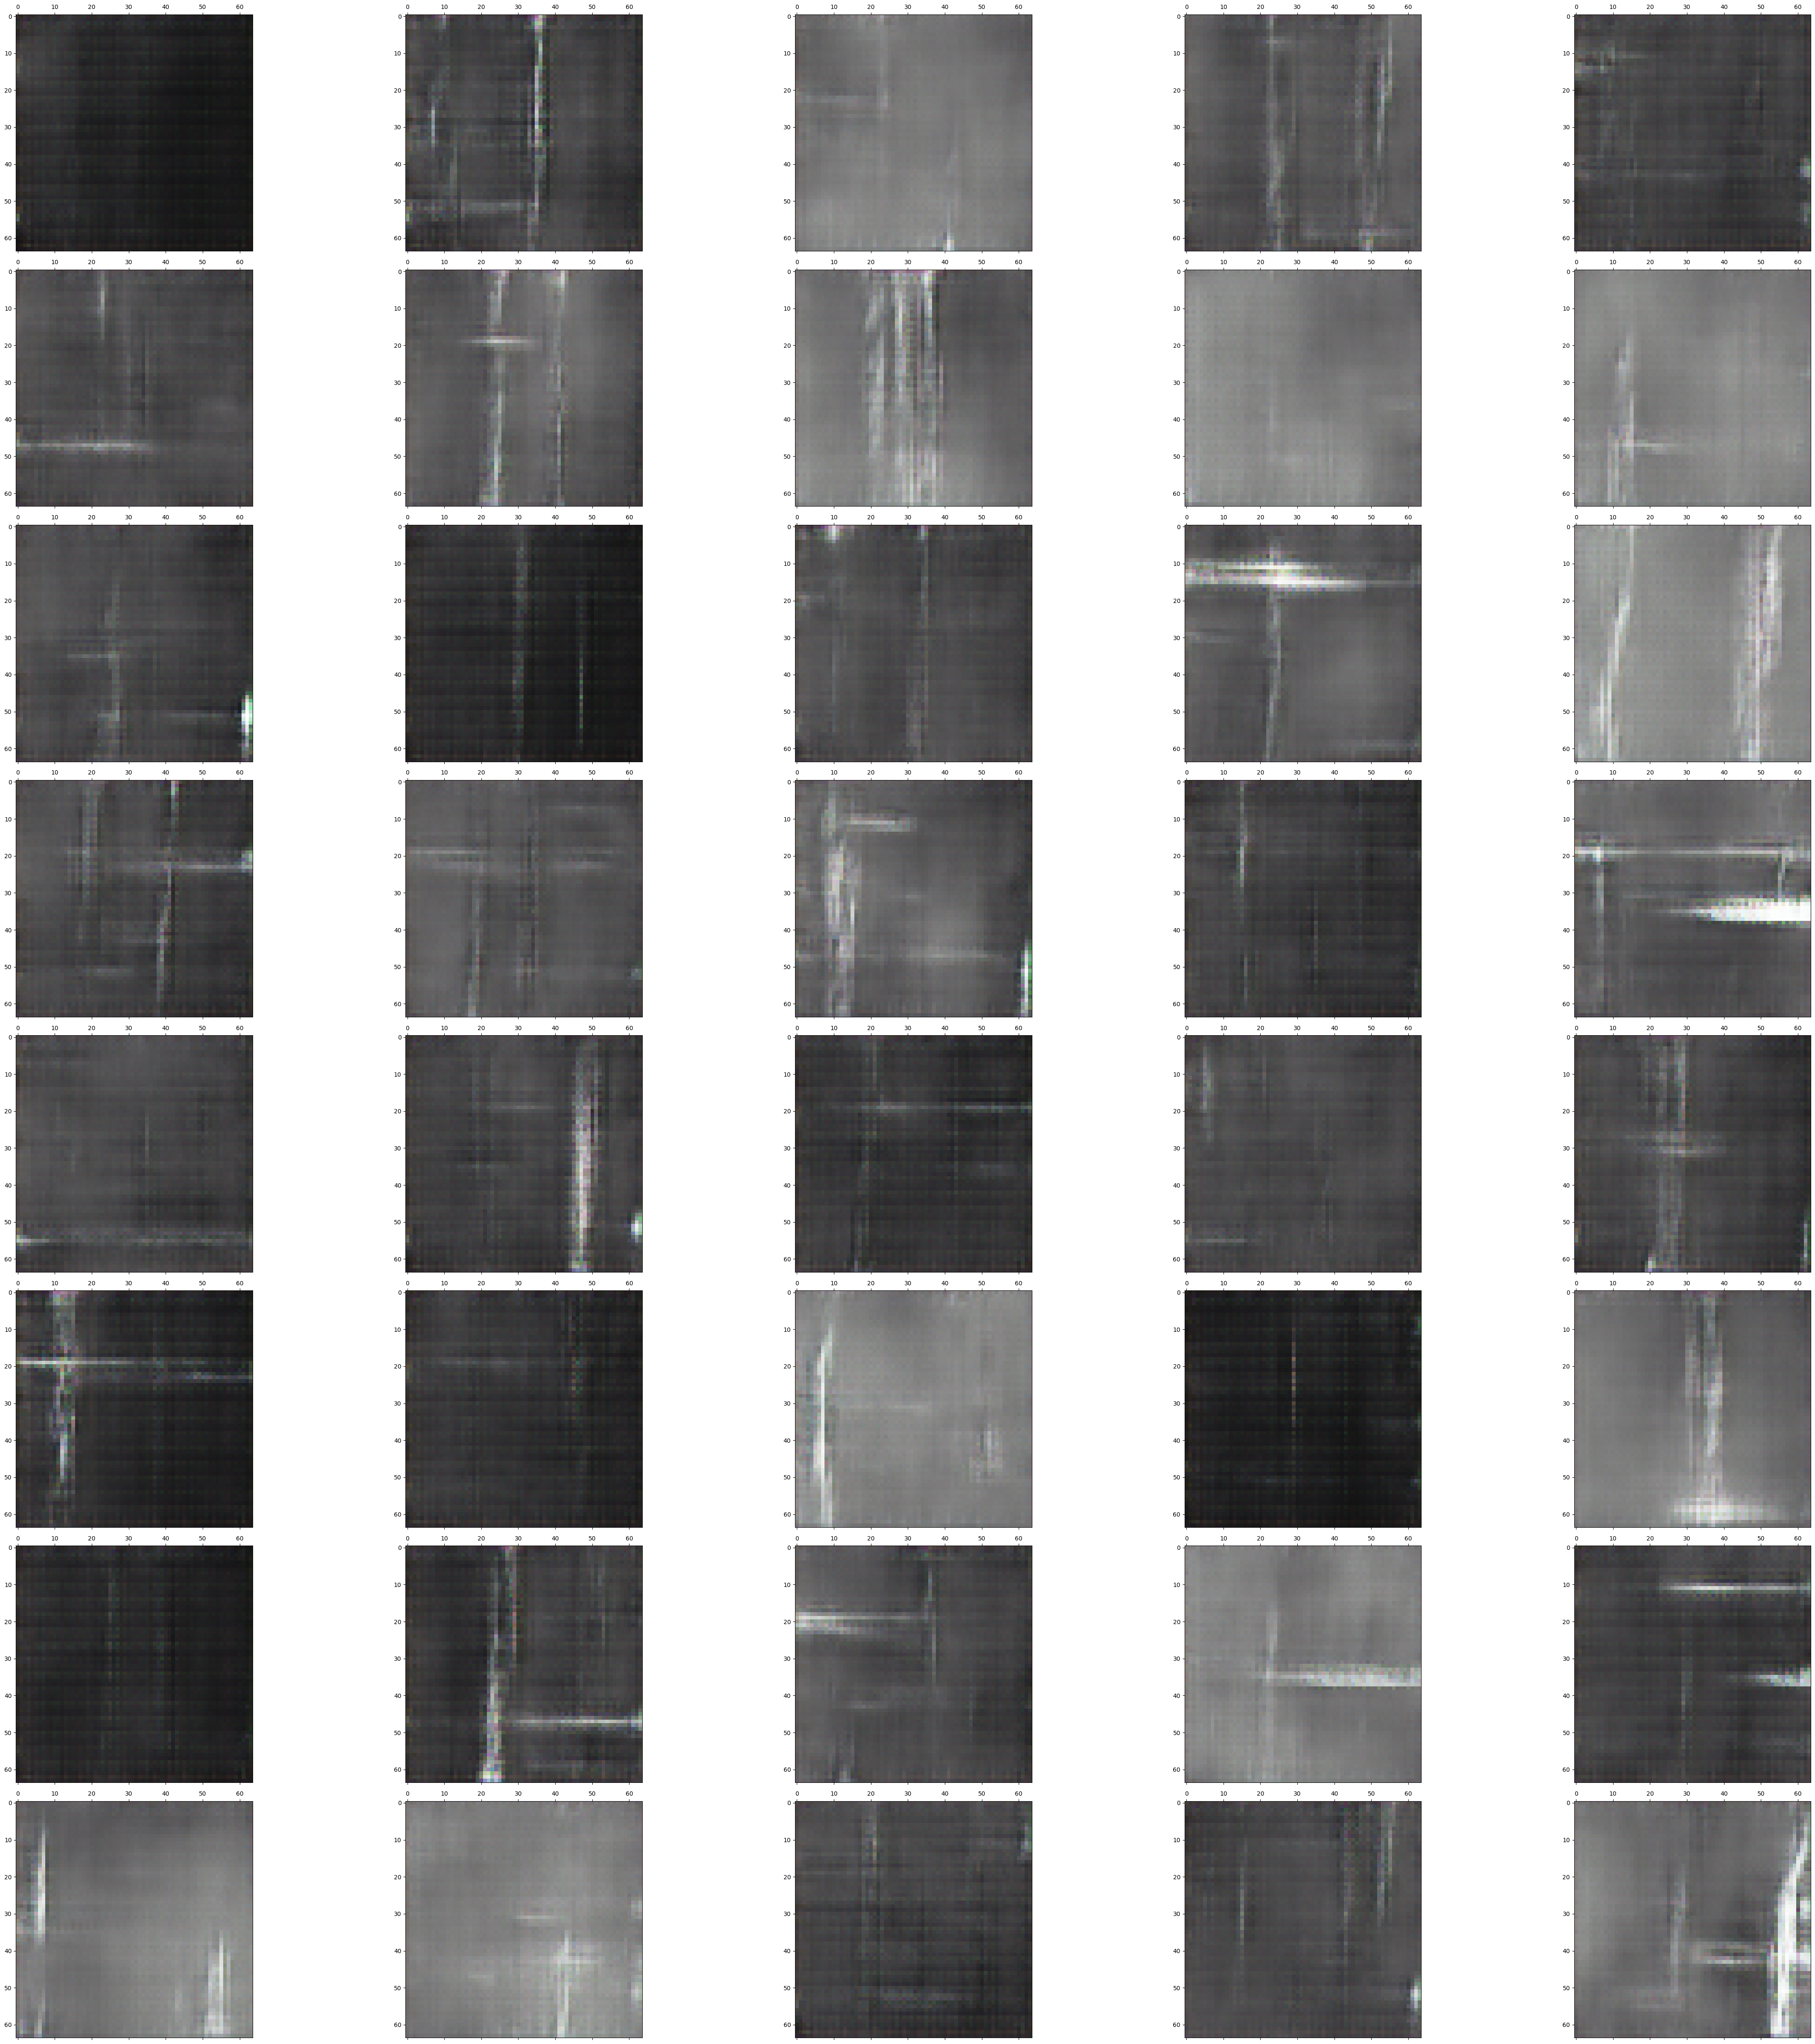

In [ ]:
# After 2K epochs
performance_eval(0, gen_model, dis_model, data, 200)

In [ ]:
# # After 3K epochs
# performance_eval(0, gen_model, dis_model, data, 200)

---

In [ ]:
# # After 4K epochs
# performance_eval(0, gen_model, dis_model, data, 100
# )

### Appendix - Generate one random Image

In [ ]:
# Generate an image of a bonsai tree using random latent vector
x_fake, y_fake = fake_samples(gen_model, 200, 1)

# Shape and inverse transpose the generated image
x_fake_inv_trans=x_fake.reshape(-1, 1)
x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
x_fake_inv_trans=x_fake_inv_trans.reshape(64, 64, 3)

1/1 [==============================] - 0s 22ms/step


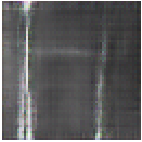

In [ ]:
# Show the generated image
fig, ax = plt.subplots(figsize=(16,9), dpi=20)
ax.matshow(x_fake_inv_trans)
plt.axis('off')
plt.show()